In [48]:
!pip install cupy-cuda12x

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [49]:
!pip install attention

In [50]:
import os
import numpy as np
import cupy as cp
# import numba as nb
import datetime as dt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import h5py
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape
from keras.models import Sequential
from keras.optimizers import Adam


In [51]:
len(tf.config.list_physical_devices('GPU'))

1

In [52]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [53]:
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [54]:
tf.test.is_gpu_available

<function tensorflow.python.framework.test_util.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)>

In [55]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [56]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [57]:
tf.config.experimental.enable_op_determinism()

In [58]:
df = pd.read_csv('/kaggle/input/deep-learning-timeseries-forecast/Impute_misvalues_hungyen.csv')
df.head()

Date Hour  Waterlevel
0  1/1/2008    0        47.0
1  1/1/2008    1        43.0
2  1/1/2008    2        40.0
3  1/1/2008    3        37.0
4  1/1/2008    4        34.0

In [59]:
df['Hour'] = df['Hour'].replace('#NUM!', 0)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64061 entries, 0 to 64060
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        64061 non-null  object 
 1   Hour        64061 non-null  object 
 2   Waterlevel  64061 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ MB


In [61]:
df.describe()

Waterlevel
count  64061.000000
mean     138.135113
std       97.020489
min      -26.000000
25%       75.000000
50%      116.000000
75%      171.000000
max      651.000000

In [62]:
df.isnull().sum()

Date          0
Hour          0
Waterlevel    0
dtype: int64

In [63]:
df['Hour'] = pd.to_datetime(df['Hour'], format='%H', errors='coerce').dt.time
df.head()

Date      Hour  Waterlevel
0  1/1/2008  00:00:00        47.0
1  1/1/2008  01:00:00        43.0
2  1/1/2008  02:00:00        40.0
3  1/1/2008  03:00:00        37.0
4  1/1/2008  04:00:00        34.0

In [64]:
df['Hour'] = df['Hour'].astype(str)


df['DateTime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Hour']
        )
df = df.set_index('DateTime')
df.drop(['Date', 'Hour'], 
        axis = 1, inplace = True)

df.head()

Waterlevel
DateTime                       
2008-01-01 00:00:00        47.0
2008-01-01 01:00:00        43.0
2008-01-01 02:00:00        40.0
2008-01-01 03:00:00        37.0
2008-01-01 04:00:00        34.0

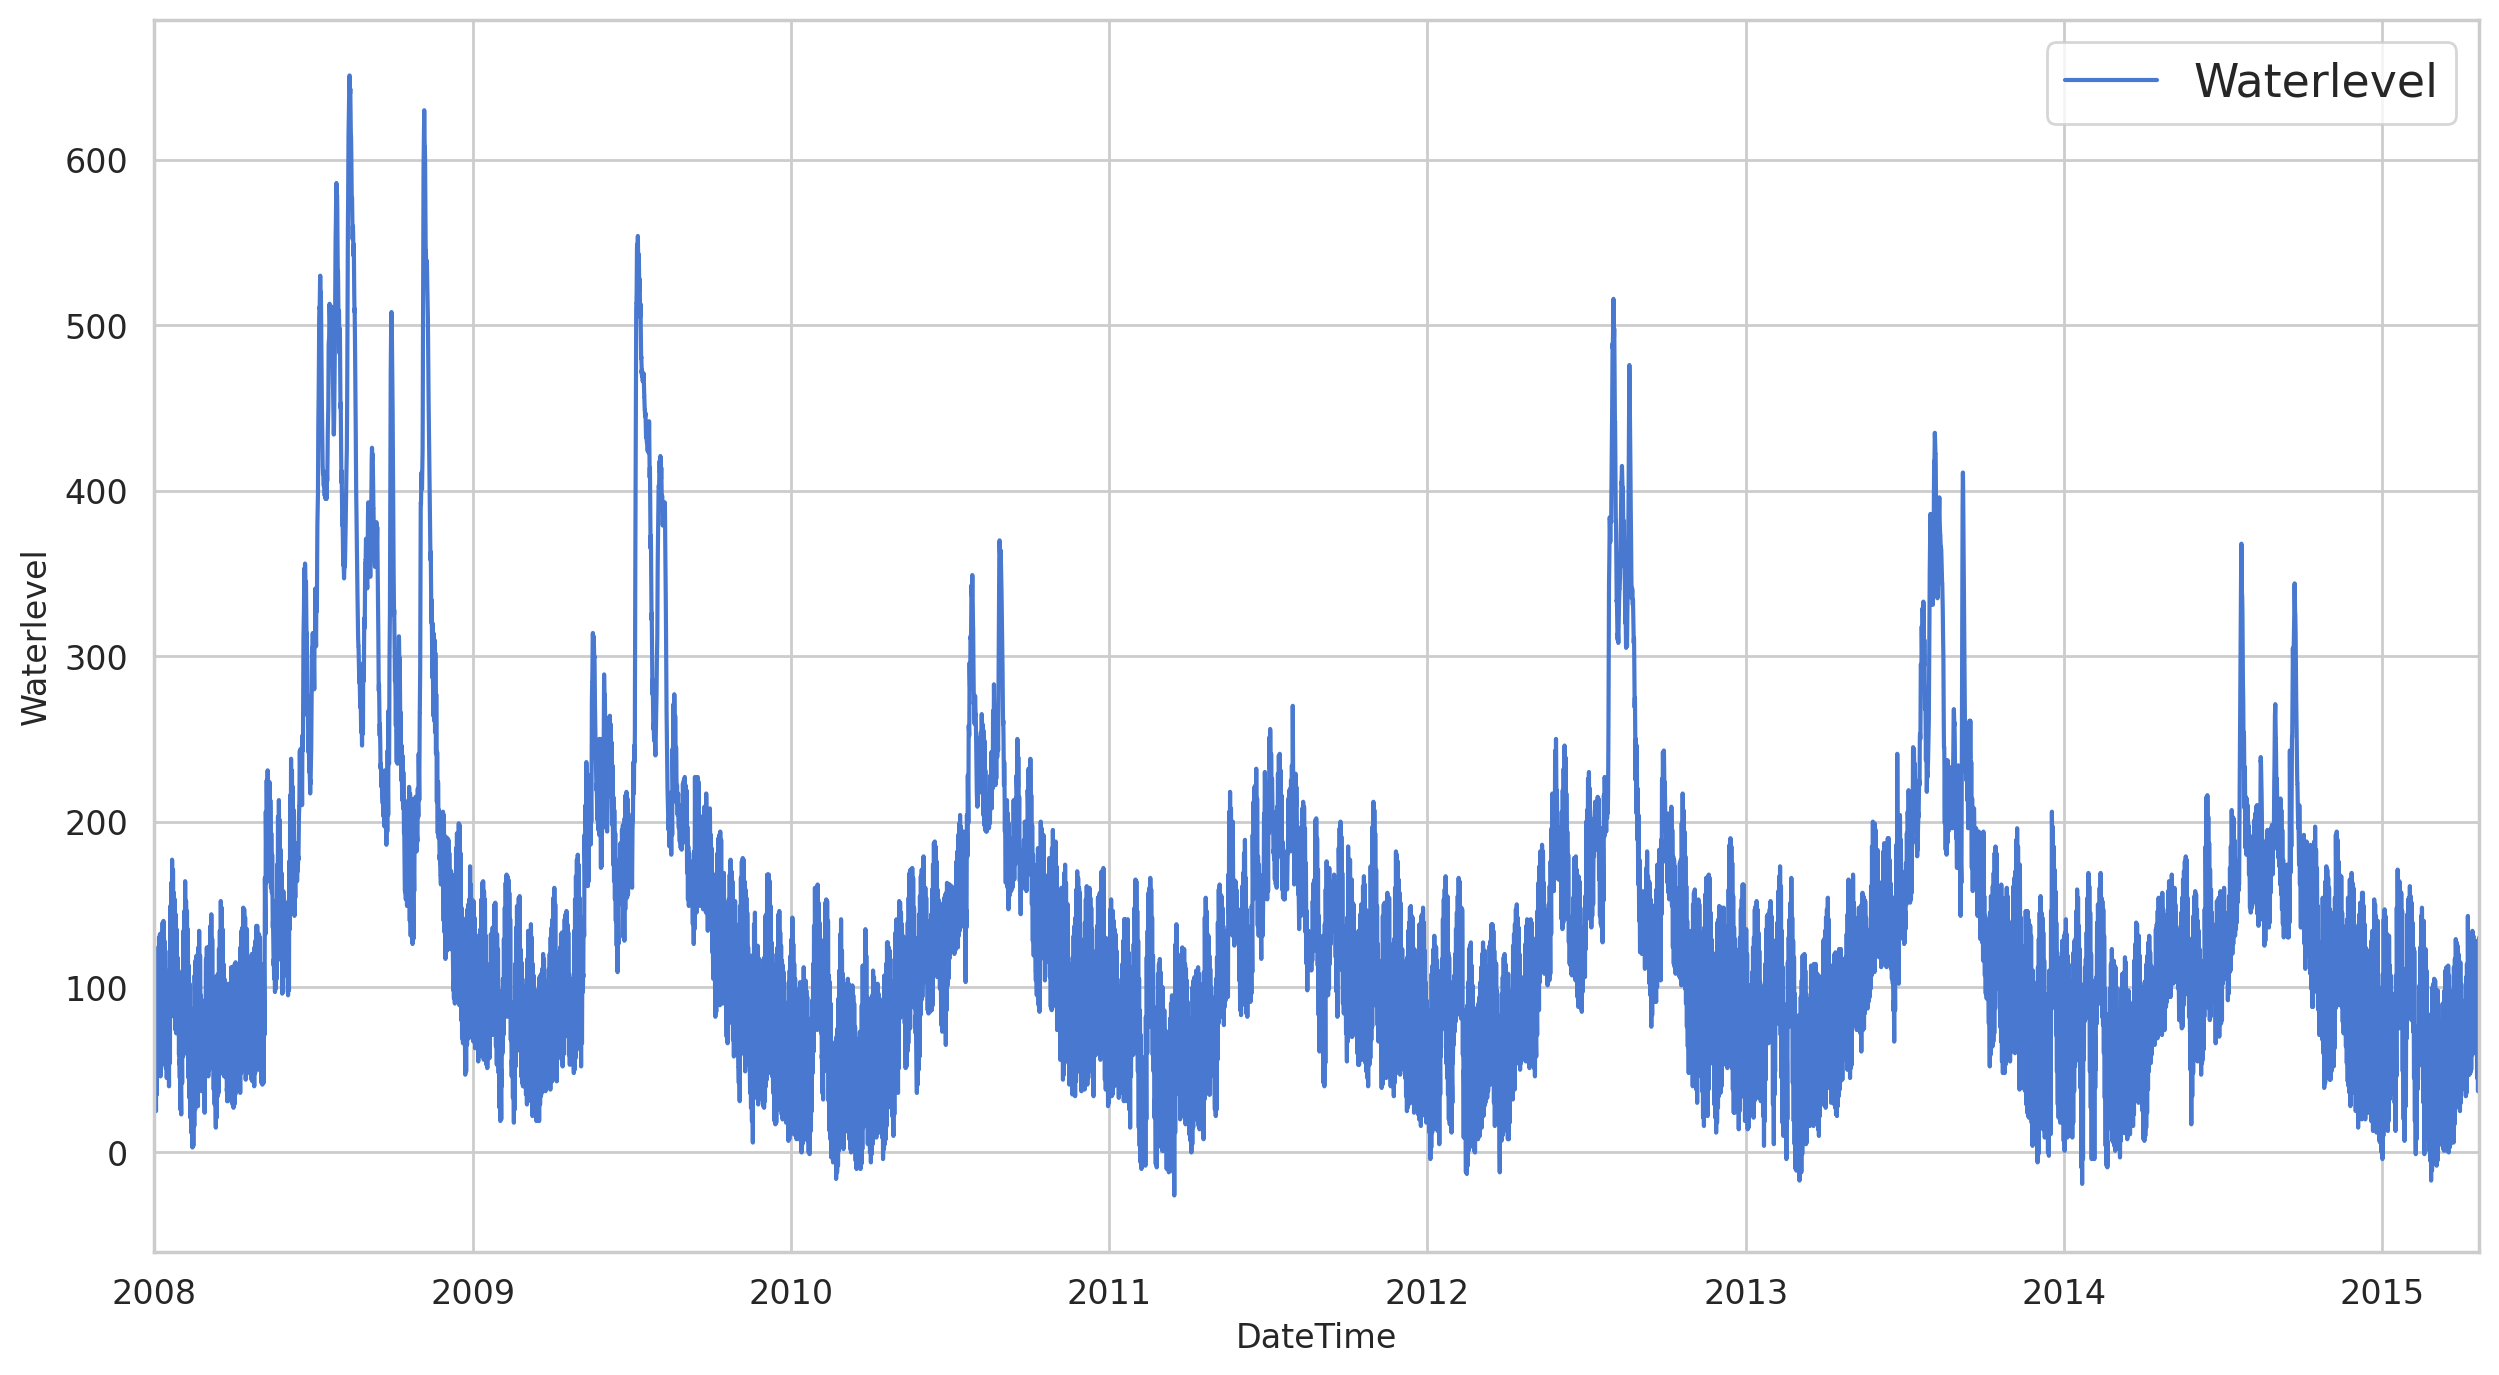

In [65]:
df.plot(y='Waterlevel', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)
plt.show()

In [66]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.85)
train, val, test = df[:train_size].iloc[:, [-1]], df[train_size:val_size].iloc[:, [-1]] , df[val_size:].iloc[:, [-1]]

train, val, test

(                     Waterlevel
 DateTime                       
 2008-01-01 00:00:00        47.0
 2008-01-01 01:00:00        43.0
 2008-01-01 02:00:00        40.0
 2008-01-01 03:00:00        37.0
 2008-01-01 04:00:00        34.0
 ...                         ...
 2013-02-11 05:00:00        86.0
 2013-02-11 06:00:00       100.0
 2013-02-11 07:00:00       115.0
 2013-02-11 08:00:00       128.0
 2013-02-11 09:00:00       134.0
 
 [44842 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2013-02-11 10:00:00       133.0
 2013-02-11 11:00:00       127.0
 2013-02-11 12:00:00       122.0
 2013-02-11 13:00:00       115.0
 2013-02-11 14:00:00       107.0
 ...                         ...
 2014-03-18 14:00:00        46.0
 2014-03-18 15:00:00        54.0
 2014-03-18 16:00:00        61.0
 2014-03-18 17:00:00        65.0
 2014-03-18 18:00:00        65.0
 
 [9609 rows x 1 columns],
                      Waterlevel
 DateTime                       
 2014-03-18 19:00:0

In [67]:
train.shape, val.shape, test.shape

((44842, 1), (9609, 1), (9610, 1))

Text(0, 0.5, 'Waterlevel')

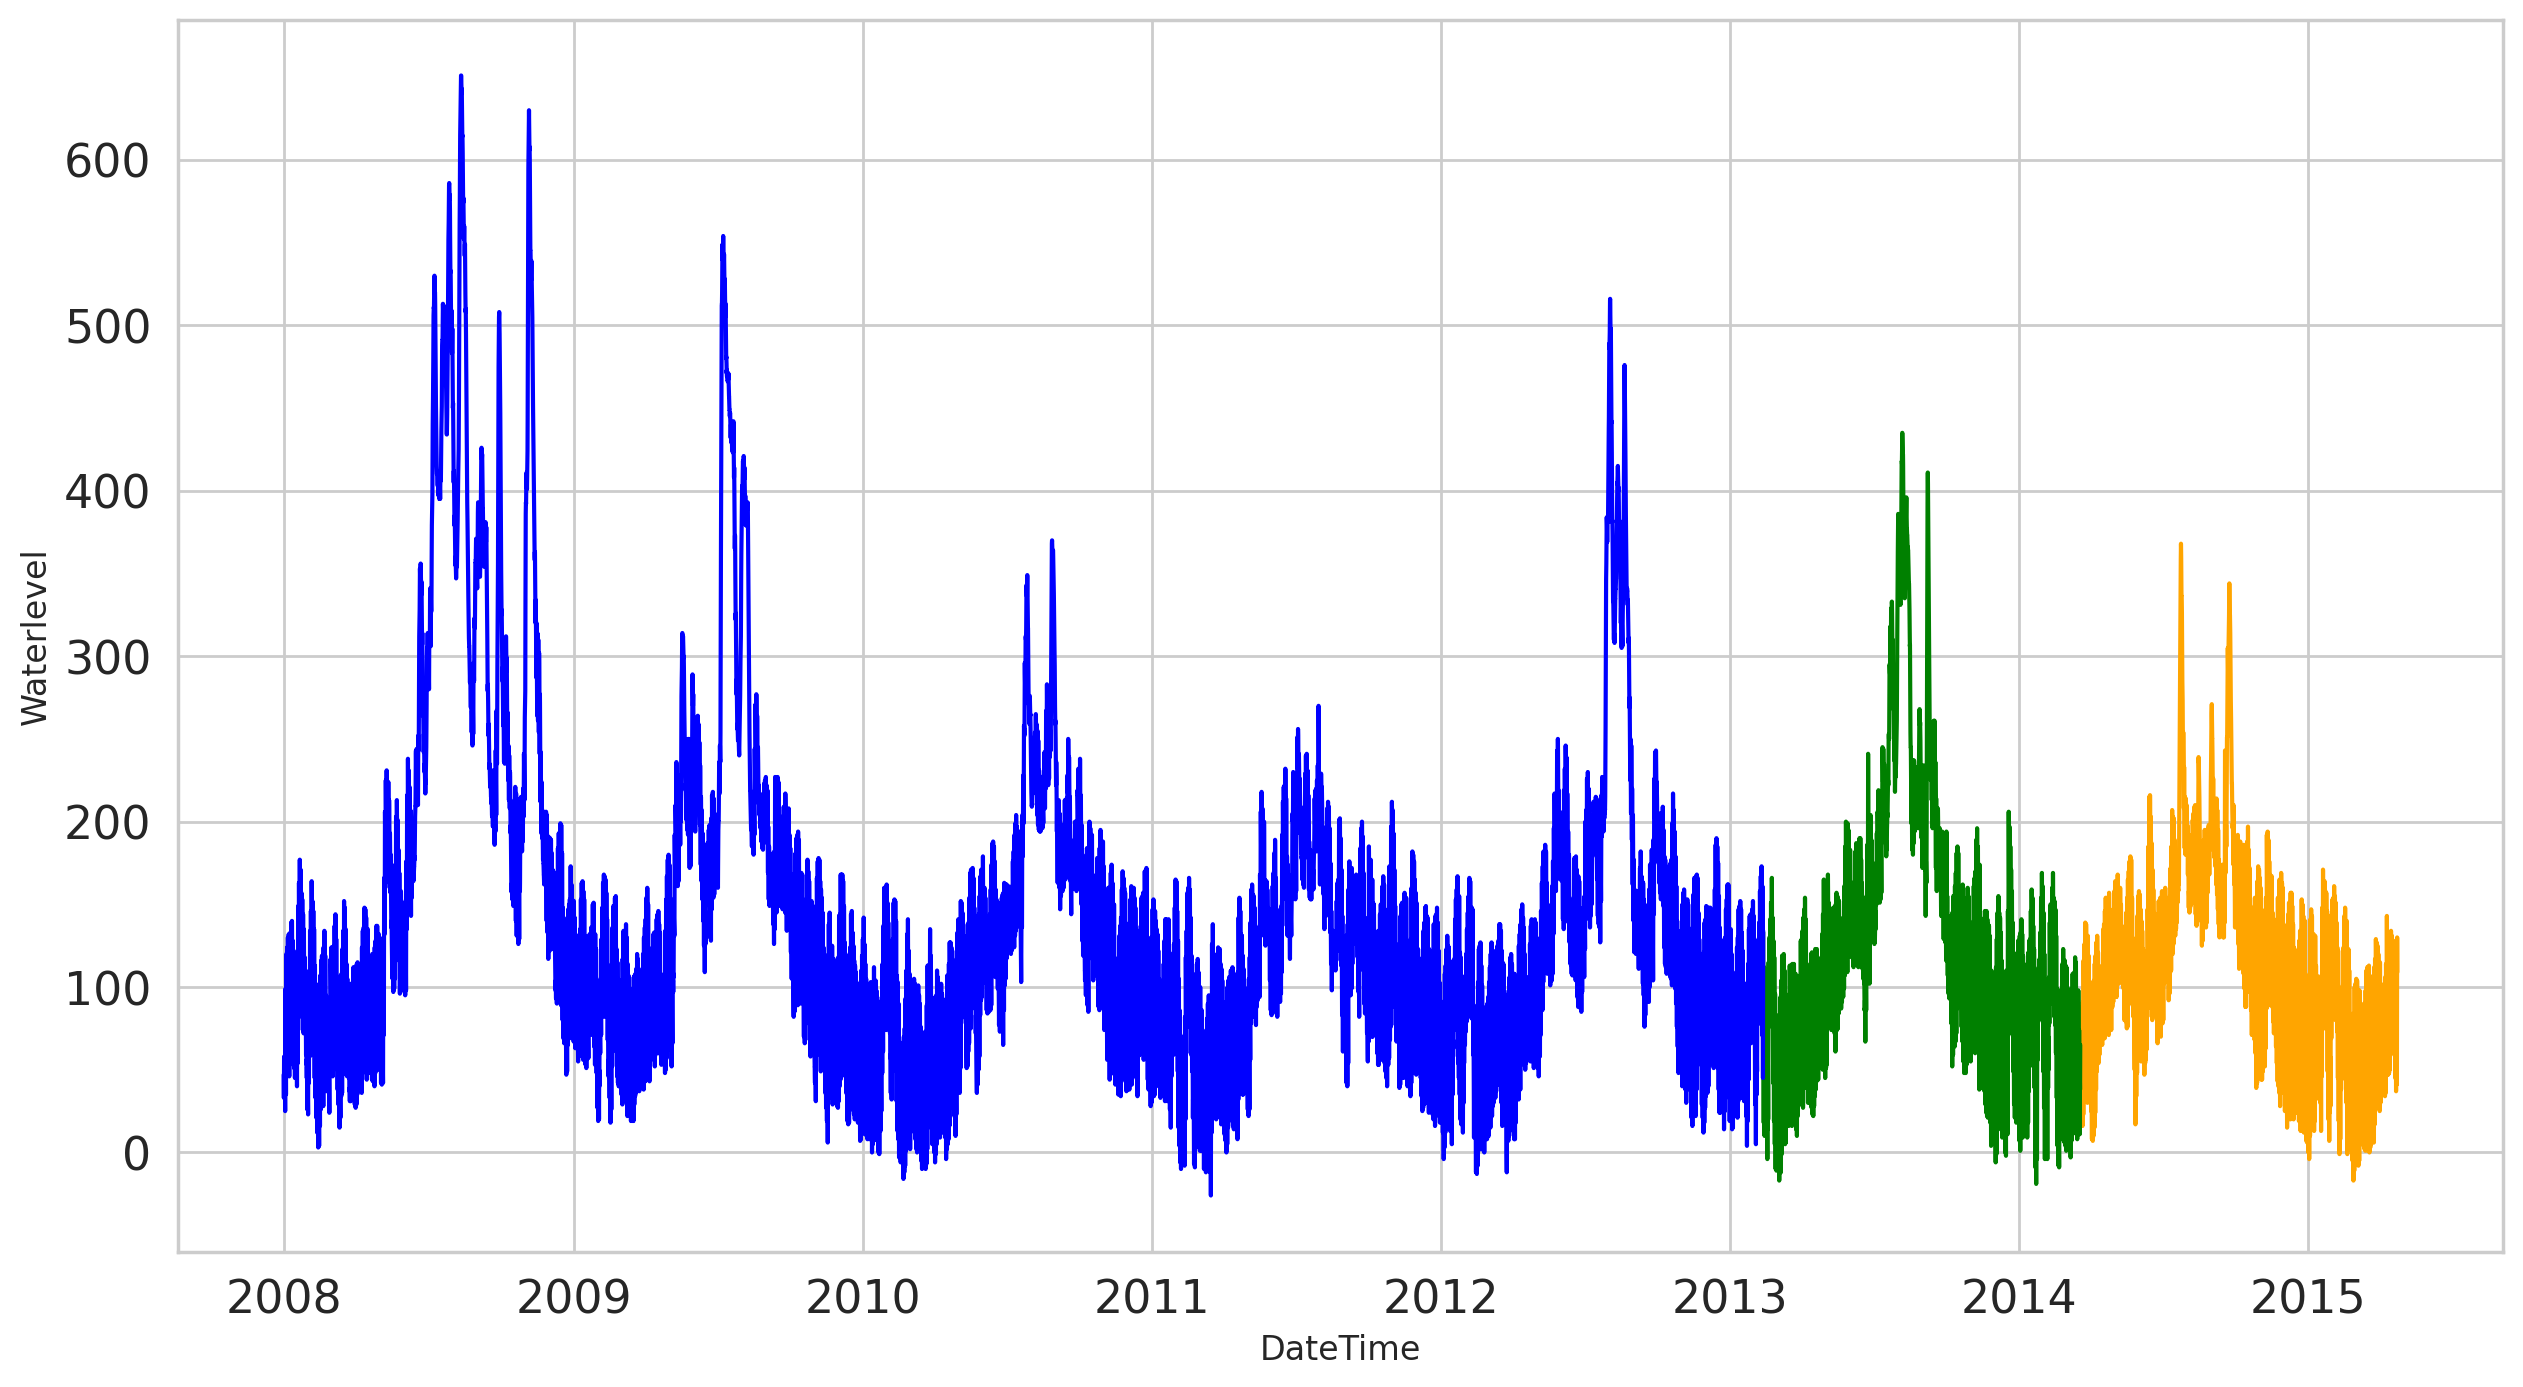

In [68]:
plt.figure(figsize = (15,8))
plt.plot(test.index, test['Waterlevel'], label = "test", color = 'orange')
plt.plot(val.index, val['Waterlevel'], label = "val", color = 'green')
plt.plot(train.index, train['Waterlevel'], label = "train" , color = 'blue')
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('Waterlevel', fontsize=12)

In [69]:
scaler = MinMaxScaler()
train['Waterlevel'] = scaler.fit_transform(train)
val['Waterlevel'] = scaler.transform(val)
test['Waterlevel'] = scaler.transform(test)

In [70]:
train_data = train.values
val_data = val.values
test_data = test.values

In [71]:
timesteps = 164

In [72]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] 
                               for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
val_data_timesteps=np.array([[j for j in val_data[i:i+timesteps]] 
                             for i in range(0,len(val_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] 
                              for i in range(0,len(test_data)-timesteps+1)])[:,:,0]


In [73]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_val, y_val = val_data_timesteps[:,:timesteps-1],val_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

x_train, y_train

(array([[0.10782866, 0.10192024, 0.09748892, ..., 0.17282127, 0.16395864,
         0.15509601],
        [0.10192024, 0.09748892, 0.09305761, ..., 0.16395864, 0.15509601,
         0.14623338],
        [0.09748892, 0.09305761, 0.08862629, ..., 0.15509601, 0.14623338,
         0.13737075],
        ...,
        [0.1816839 , 0.17725258, 0.17282127, ..., 0.14327917, 0.16543575,
         0.18611521],
        [0.17725258, 0.17282127, 0.16838996, ..., 0.16543575, 0.18611521,
         0.20827179],
        [0.17282127, 0.16838996, 0.16395864, ..., 0.18611521, 0.20827179,
         0.22747415]]),
 array([[0.14623338],
        [0.13737075],
        [0.12998523],
        ...,
        [0.20827179],
        [0.22747415],
        [0.23633678]]))

In [74]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    squared_error = np.mean((y_true - y_pred)**2)

    r, _ = pearsonr(y_true, y_pred)
    
    T = len(y_true)
    max_x = max(y_true)
    min_x = min(y_true)
    
    sim_sum = 0
    for i in range(T):
        sim_sum += 1 / (1 + abs(y_pred[i] - y_true[i]) / (max_x - min_x))
    sim = sim_sum / T
    
    sd_y = np.std(y_pred)
    sd_x = np.std(y_test)
    fsd = 2 * np.abs(sd_y - sd_x) / (sd_y + sd_x)
    
    nse = 1 - (np.sum((y_pred - y_true) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MSE' : squared_error,
        'R': r,
        'SIM': sim,
        'FSD': fsd,
        'NSE': nse
    }

In [75]:
pip install keras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [77]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='uniform', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],),
                                 initializer='uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# CNN-LSTM

In [78]:
# model_5 = keras.Sequential()

# model_5.add(Conv1D(8, 3, activation='relu', padding = 'same',
#                             input_shape=(x_train.shape[1], 1)))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(Conv1D(16, 3, activation='relu', padding = 'same'))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(Conv1D(32, 3, activation='relu', padding = 'same'))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(Conv1D(64, 3, activation='relu', padding = 'same'))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(Conv1D(128, 3, activation='relu', padding = 'same'))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(Conv1D(256, 3, activation='relu', padding = 'same'))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(keras.layers.LSTM(units=256,activation = 'tanh'))
# model_5.add(Dropout(0.1))
# model_5.add(Flatten())

# model_5.add(Dense(100, 'relu'))
# model_5.add(Dropout(0.1))
# model_5.add(Dense((1), 'linear'))

# model_5.compile(
#   loss=MeanSquaredError(),
#   optimizer=Adam(learning_rate=0.0001),
#   metrics=[RootMeanSquaredError()]
# )

# model_5.fit(
#     x_train, y_train,
#     validation_data=(x_val, y_val),
#     epochs=200,
#     batch_size=32,                       
#     verbose=1,
#     shuffle=False
# )                                               
# # model_5.save('Model_5.h5')
# model_5.summary()

# CNN-LSTM-es

In [79]:
# model_5 = keras.Sequential()

# model_5.add(Conv1D(8, 3, activation='relu', padding = 'same',
#                             input_shape=(x_train.shape[1], 1)))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(Conv1D(16, 3, activation='relu', padding = 'same'))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(Conv1D(32, 3, activation='relu', padding = 'same'))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(Conv1D(64, 3, activation='relu', padding = 'same'))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(Conv1D(128, 3, activation='relu', padding = 'same'))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(Conv1D(256, 3, activation='relu', padding = 'same'))
# model_5.add(MaxPooling1D(pool_size=2, strides=2))
# model_5.add(keras.layers.LSTM(units=256,activation = 'tanh'))
# model_5.add(Dropout(0.1))
# model_5.add(Flatten())

# model_5.add(Dense(100, 'relu'))
# model_5.add(Dropout(0.1))
# model_5.add(Dense((1), 'linear'))

# model_5.compile(
#   loss=MeanSquaredError(),
#   optimizer=Adam(learning_rate=0.0001),
#   metrics=[RootMeanSquaredError()]
# )

# model_5.fit(
#     x_train, y_train,
#     validation_data=(x_val, y_val),
#     epochs=200,
#     batch_size=32,
#     callbacks=[EarlyStopping(monitor='val_loss', 
#                              patience=10, 
#                              restore_best_weights=True)],                       
#     verbose=1,
#     shuffle=False
# )                                               
# # model_5.save('Model_5.h5')
# model_5.summary()

In [80]:
# time = int(input("Enter the first time you want to forecast:"))
time = 77
hours = 120
pred = []

def forecast(model, hours, time):
    pred = []
    # current_window = x_val[-1,:].tolist()
    current_window = x_test[time,:].tolist()
    for i in range(hours):
        # Chuyển current_window thành numpy array khi gọi predict
        y_pred = model.predict(np.asarray([current_window]))[0]
        pred.append(float(y_pred[0]))
        current_window.pop(0)
        current_window.append(pred[-1])
    pred_array = np.array(pred).reshape(-1, 1)
    return pred_array

In [81]:
# y_fc = forecast(model_5, hours, time)
# y_pred = model_5.predict(x_test[time:])

# y_test_original = scaler.inverse_transform(y_test)
# y_pred_original = scaler.inverse_transform(y_pred)
# y_fc_original = scaler.inverse_transform(y_fc)

# time_forecast = [3,  6, 12, 24, 36, 72, 120]
# for hours in time_forecast:
#     plt.figure(figsize=(20, 6))
    
#     plt.plot(y_test_original[time : time + hours].flatten(), label='Actual', color='blue', marker='o')
#     plt.plot(y_pred_original[: hours], label='Predicted', color='red', marker='x')
#     plt.plot(y_fc_original[: hours].flatten(), label='Forecast', color='green', marker='x')
#     plt.title('Comparison of Actual and Predicted Values')
#     plt.xlabel('Hours')
#     plt.ylabel('Waterlevel')
#     plt.legend()

#     plt.show()
    
# for hours in time_forecast:
#     metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
#     for metric, value in metrics.items():
#         print(f'Using model LSTM {hours} hours {metric}: {value}')

#     print('\n')

In [82]:
# model_5.save('cnn_lstm_es.h5')

# LSTM

In [83]:
model_LSTM = keras.Sequential()

model_LSTM.add(keras.layers.LSTM(units=512, activation = 'tanh',
                            return_sequences=True, 
                            input_shape=(x_train.shape[1], 1)))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(keras.layers.LSTM(units=256,activation = 'tanh',
                            return_sequences=True))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(keras.layers.LSTM(units=64,activation = 'tanh',
                            return_sequences=True))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(keras.layers.LSTM(units=32))
model_LSTM.add(Flatten())
model_LSTM.add(Dense(32, 'relu'))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(Dense((1), 'linear'))

model_LSTM.compile(
  loss=MeanSquaredError(),
  optimizer=Adam(learning_rate=0.0001),
  metrics=[RootMeanSquaredError()]
)
model_LSTM.summary()
model_LSTM.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,                       
    verbose=1,
    shuffle=False
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 163, 512)          1052672   
                                                                 
 dropout_8 (Dropout)         (None, 163, 512)          0         
                                                                 
 lstm_9 (LSTM)               (None, 163, 256)          787456    
                                                                 
 dropout_9 (Dropout)         (None, 163, 256)          0         
                                                                 
 lstm_10 (LSTM)              (None, 163, 64)           82176     
                                                                 
 dropout_10 (Dropout)        (None, 163, 64)           0         
                                                                 
 lstm_11 (LSTM)              (None, 32)               

293/293 [==============================] - 6s 19ms/step


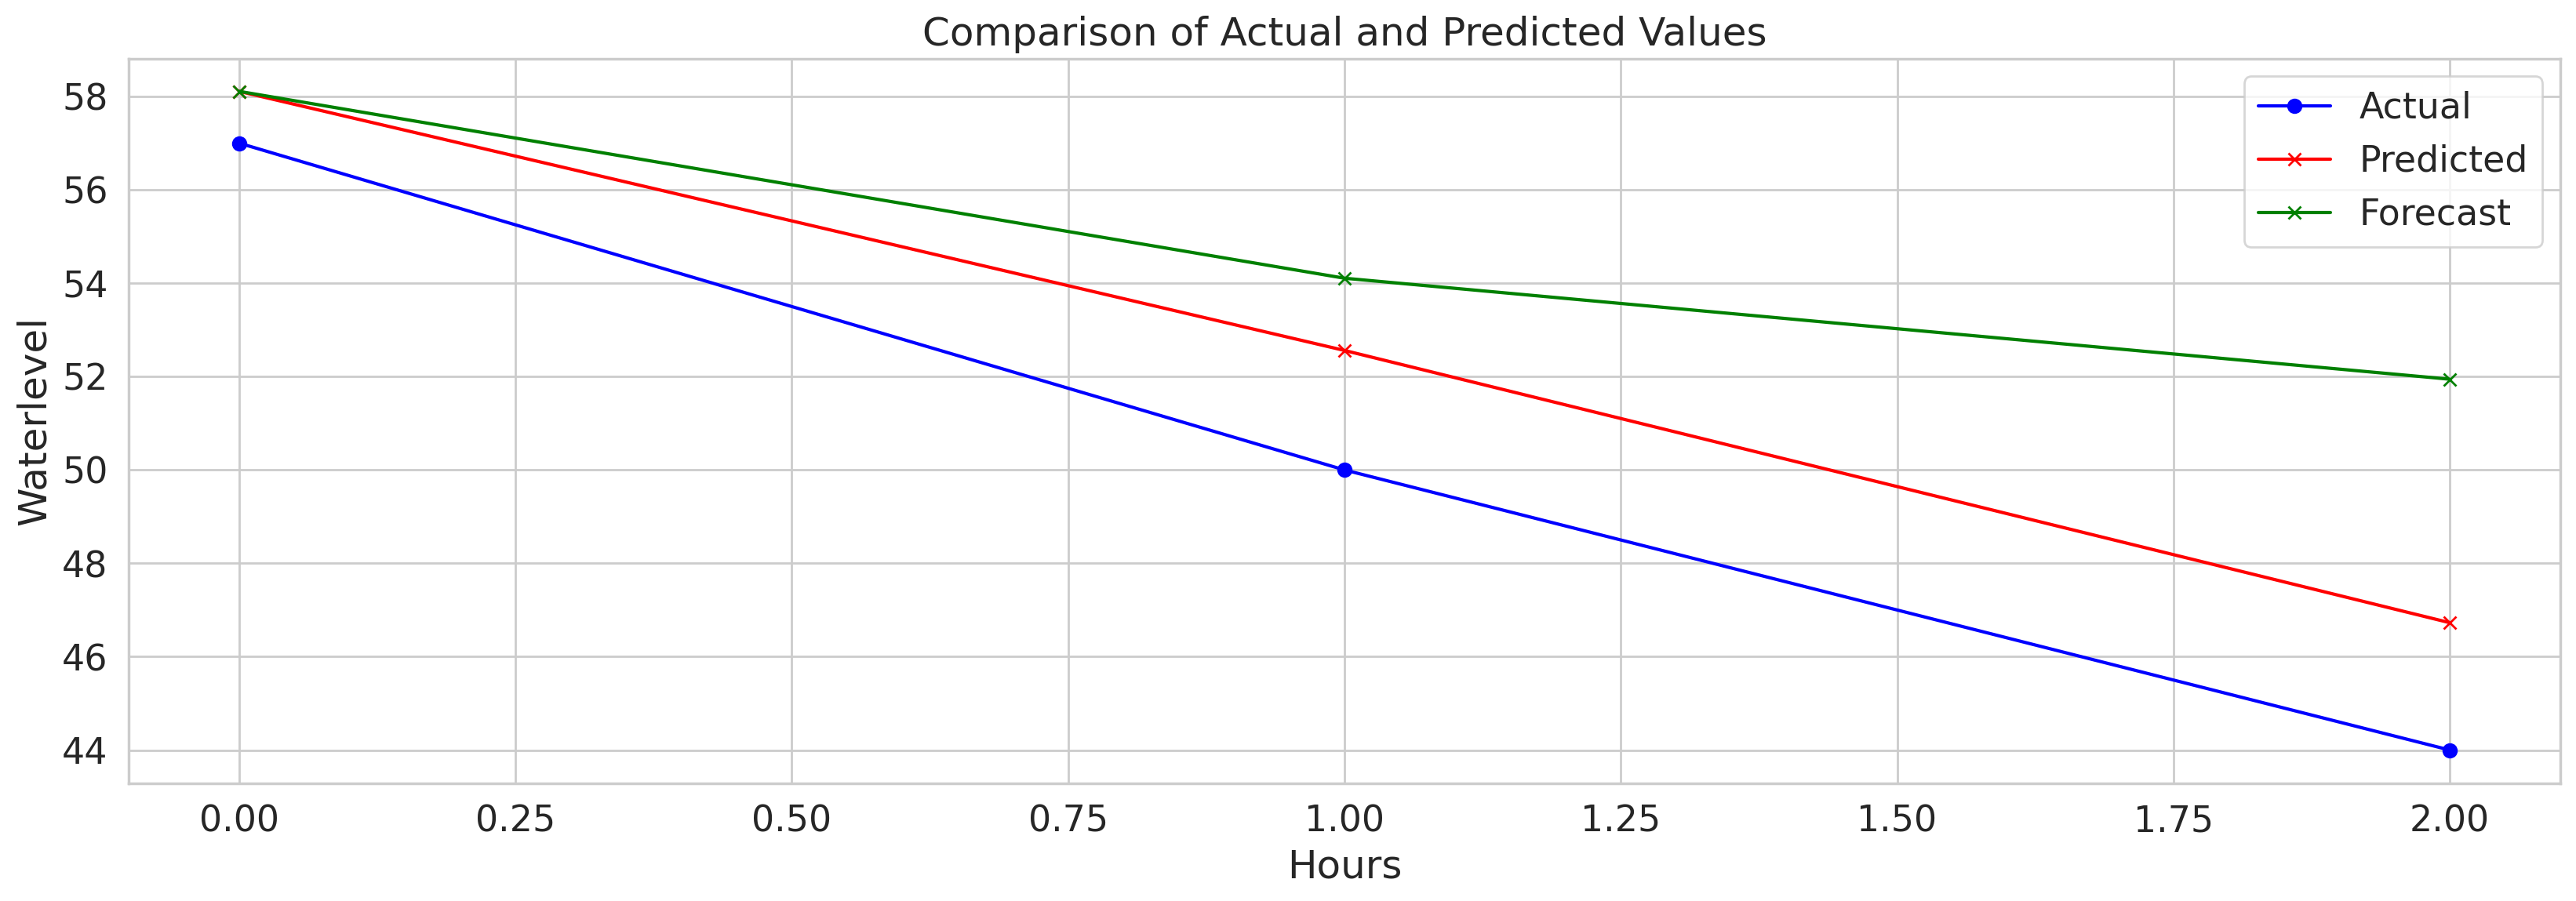

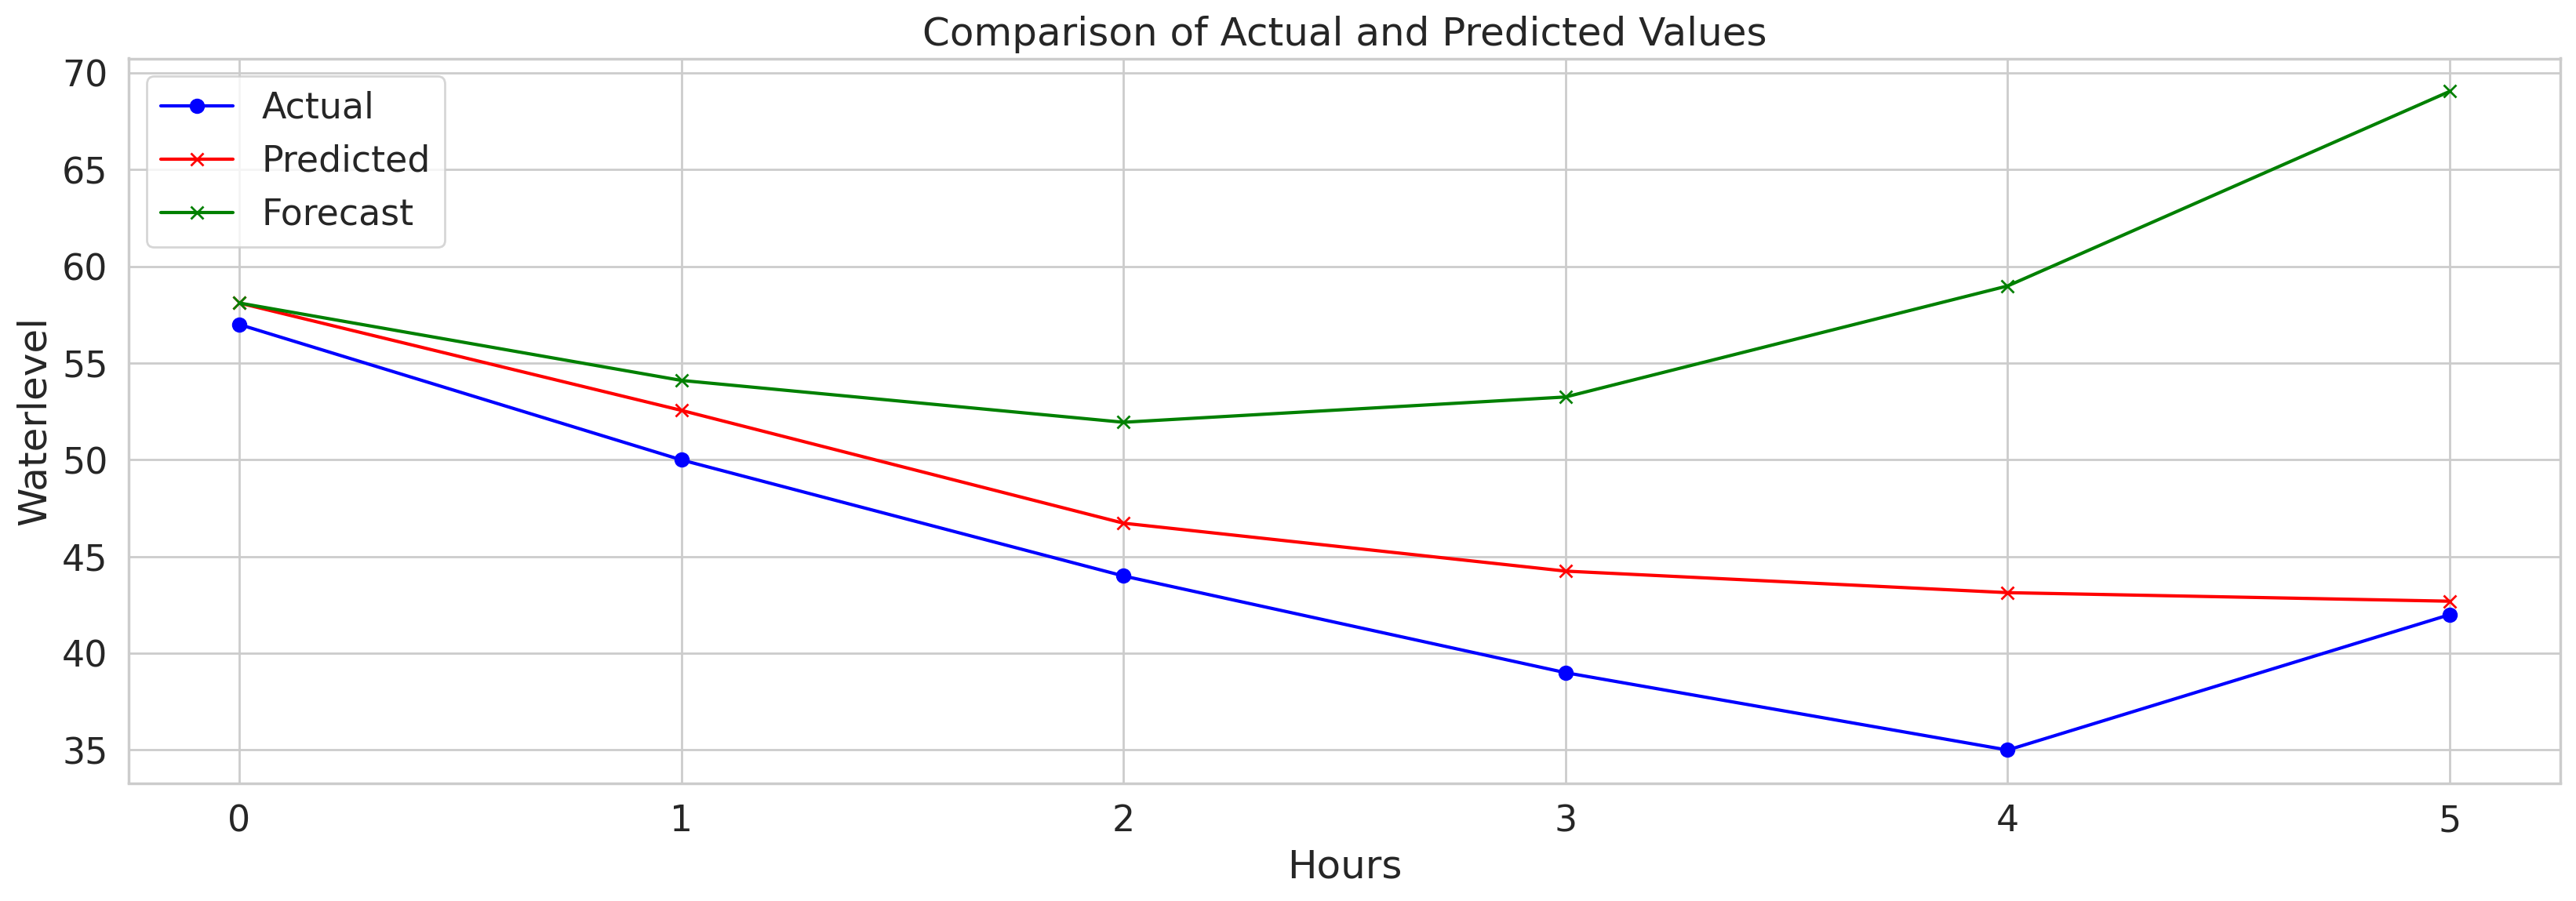

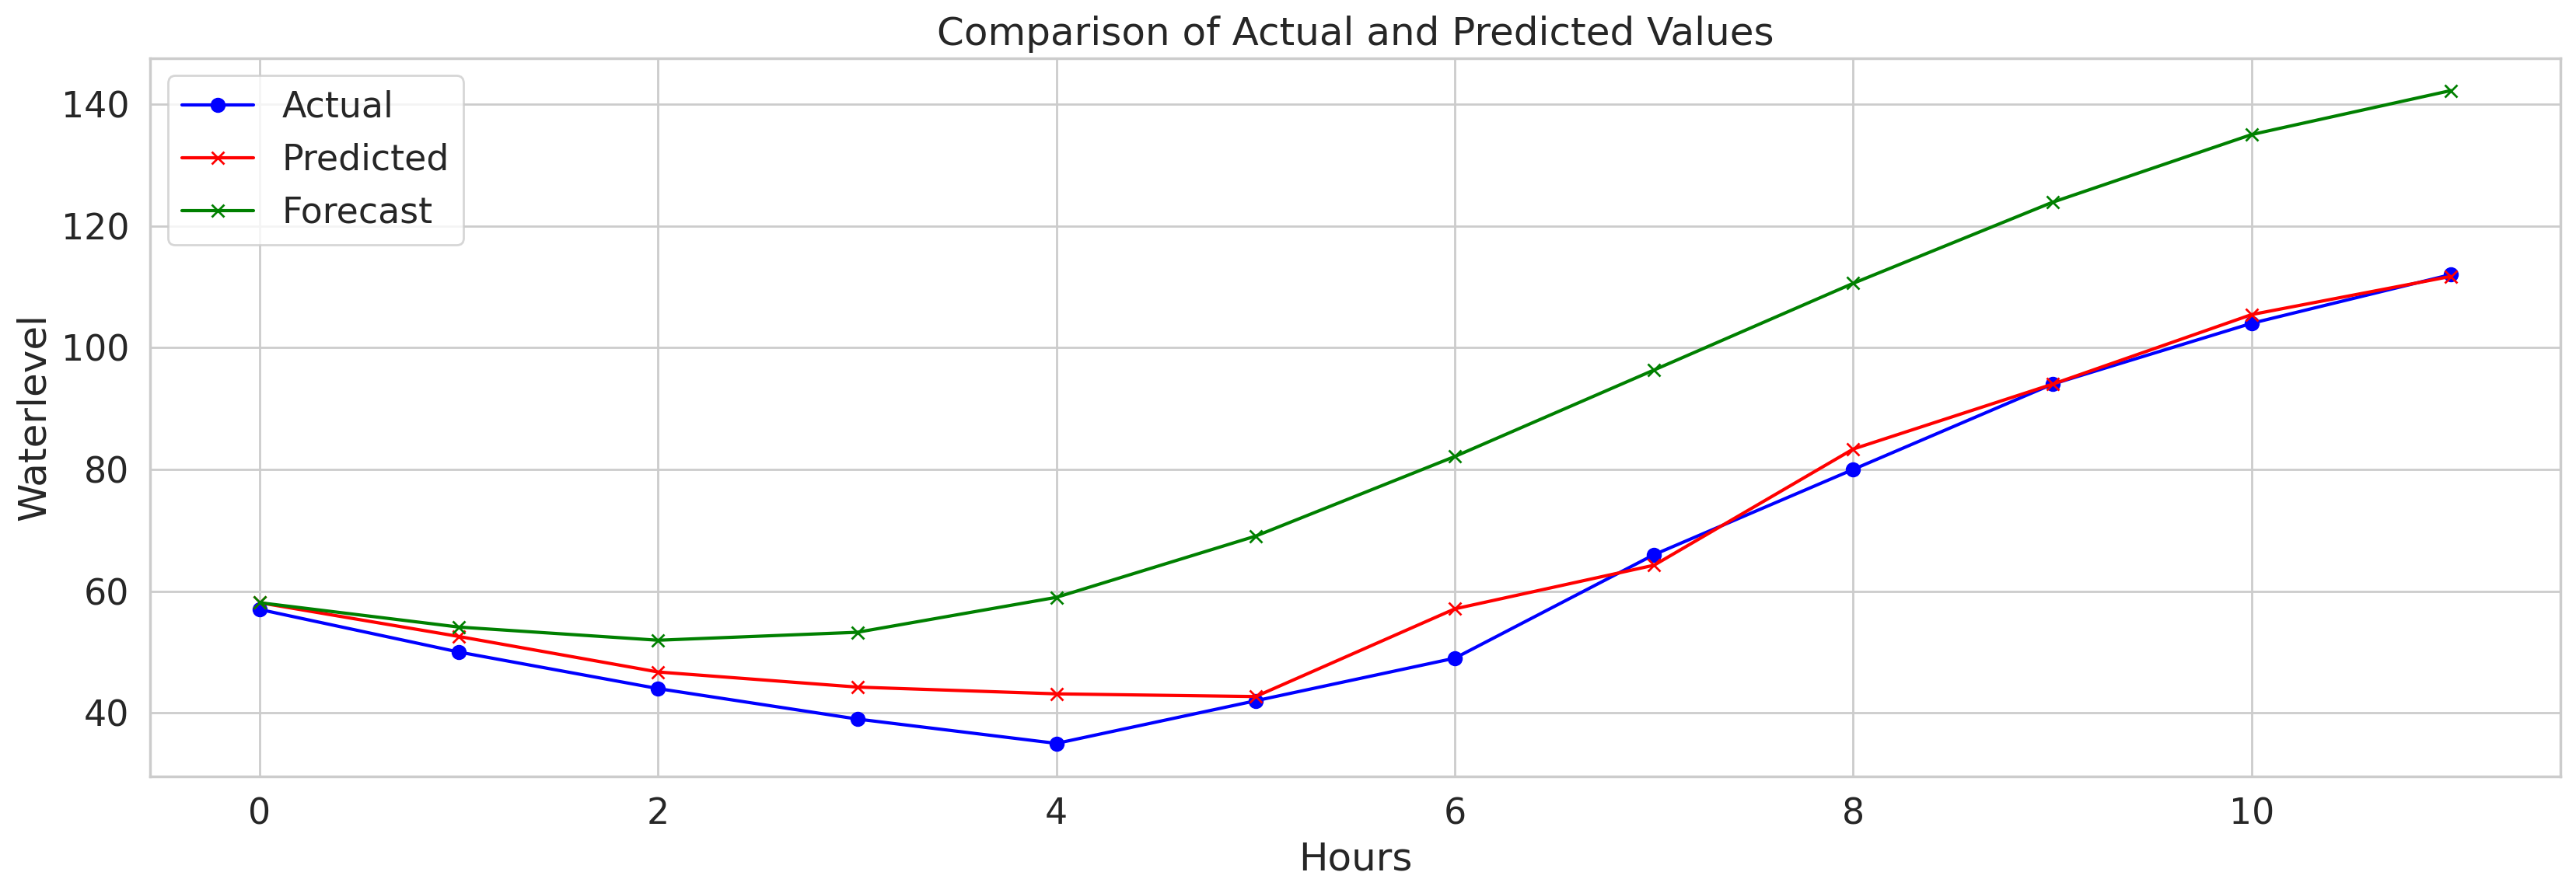

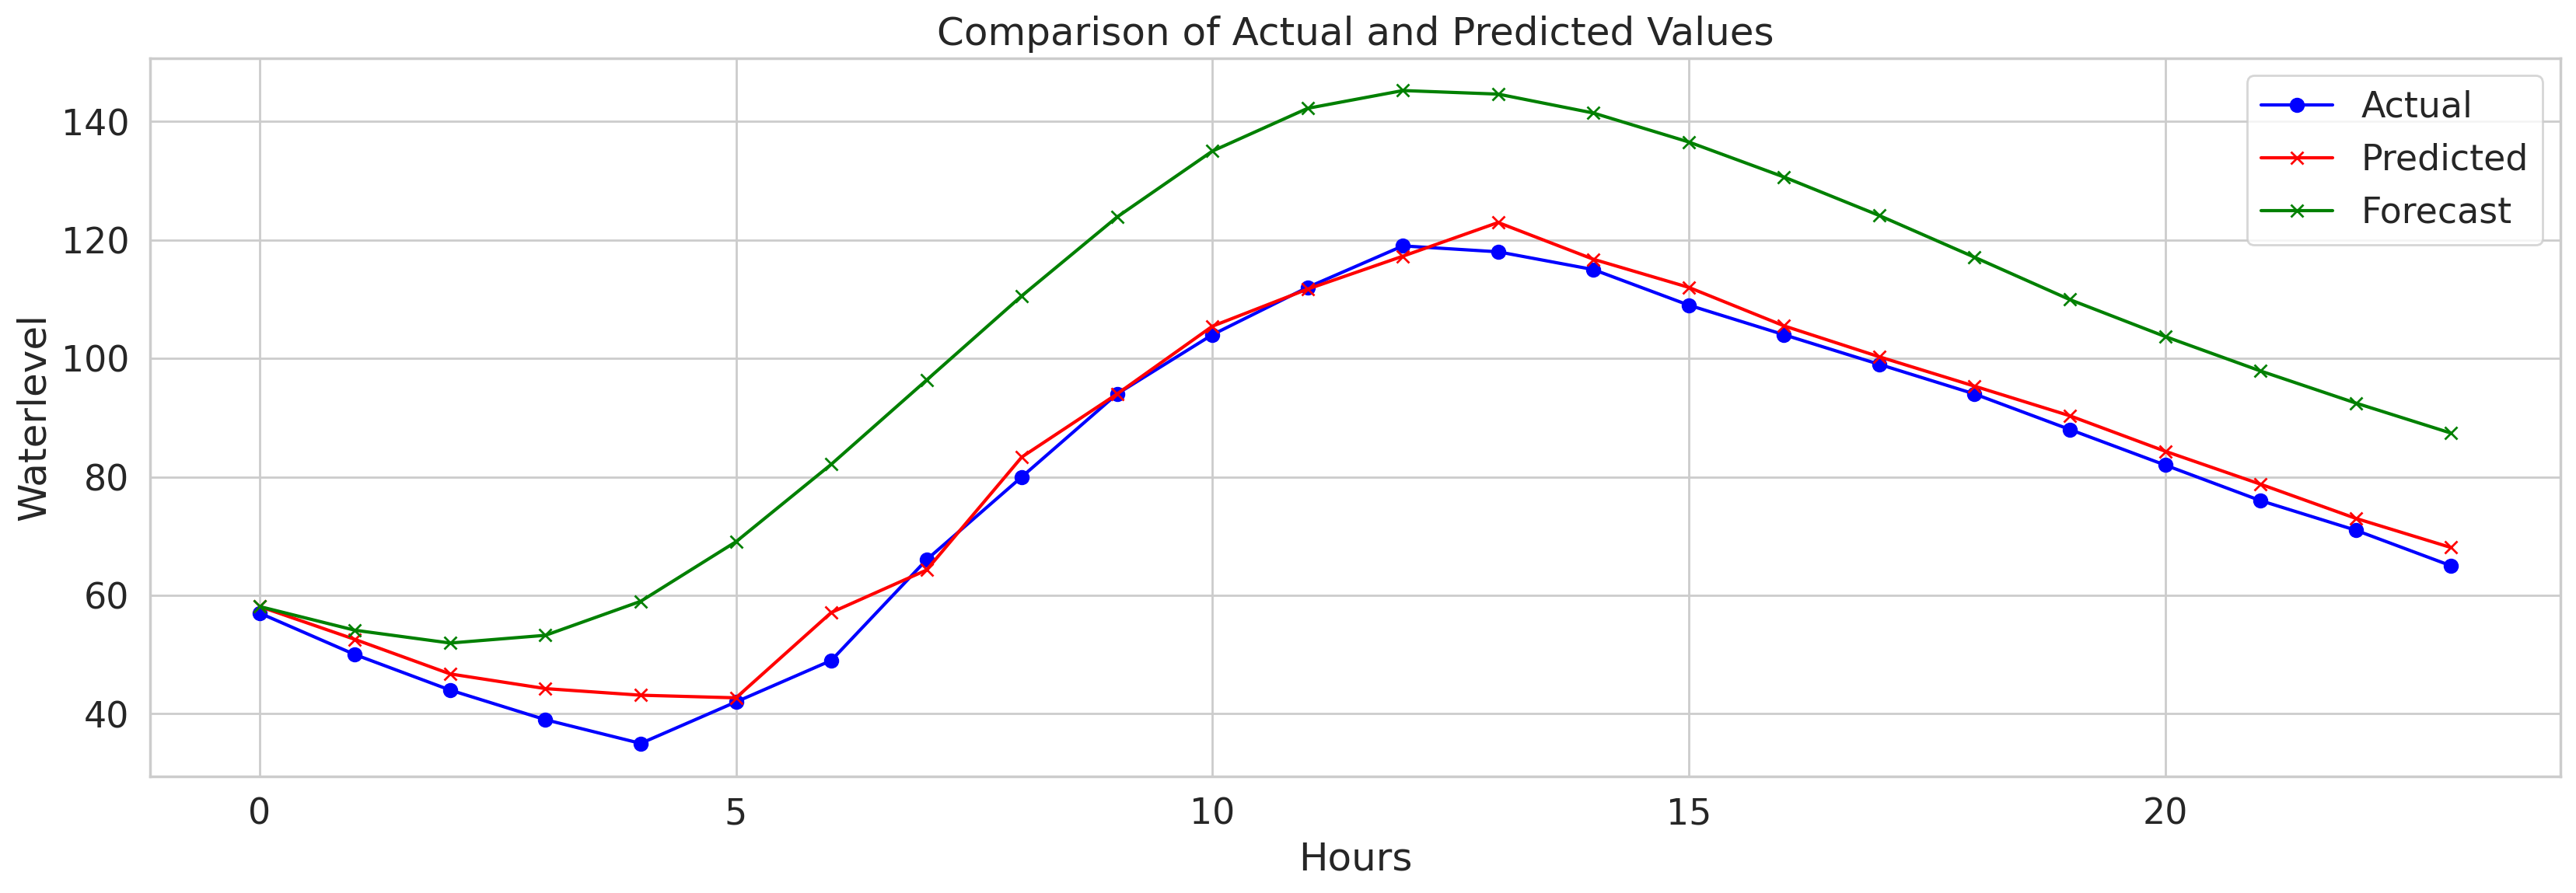

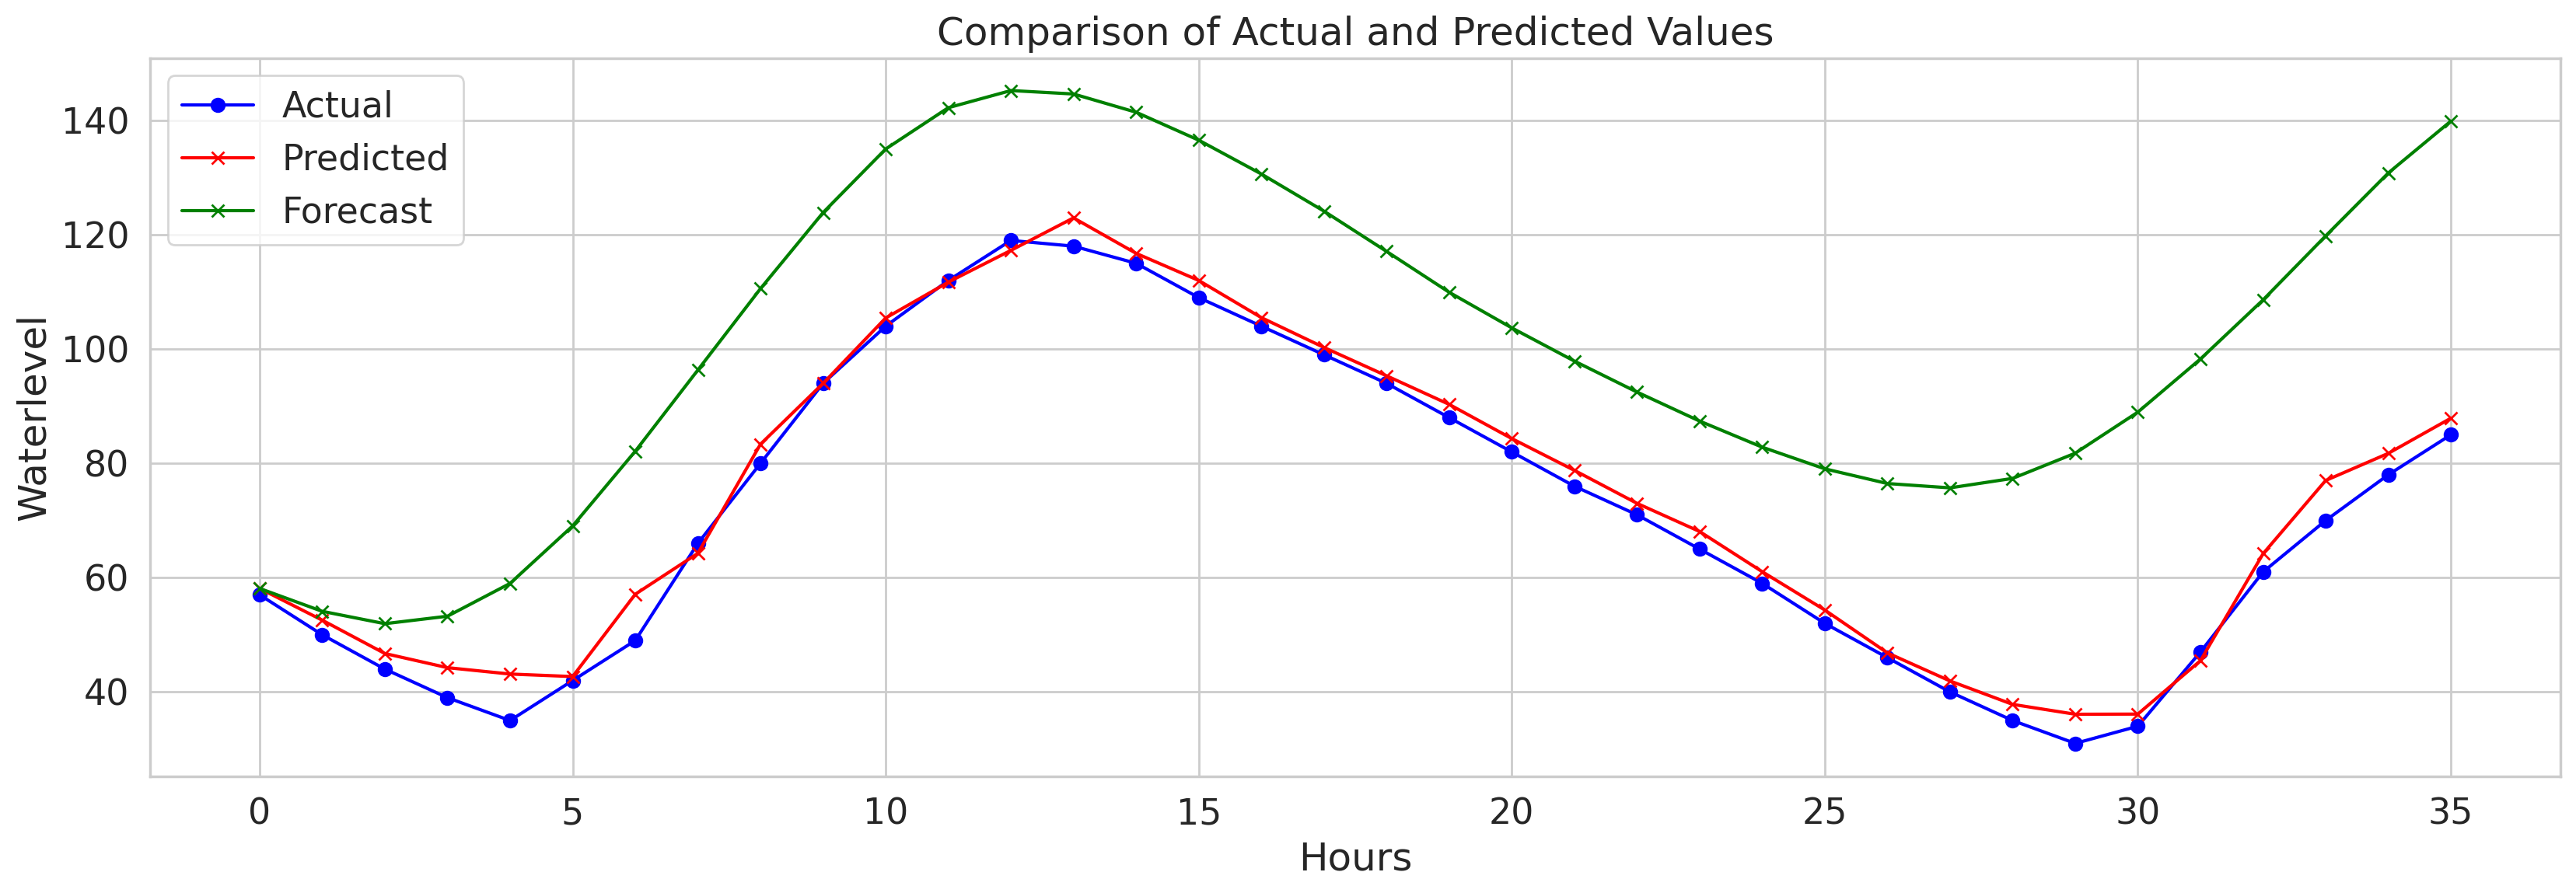

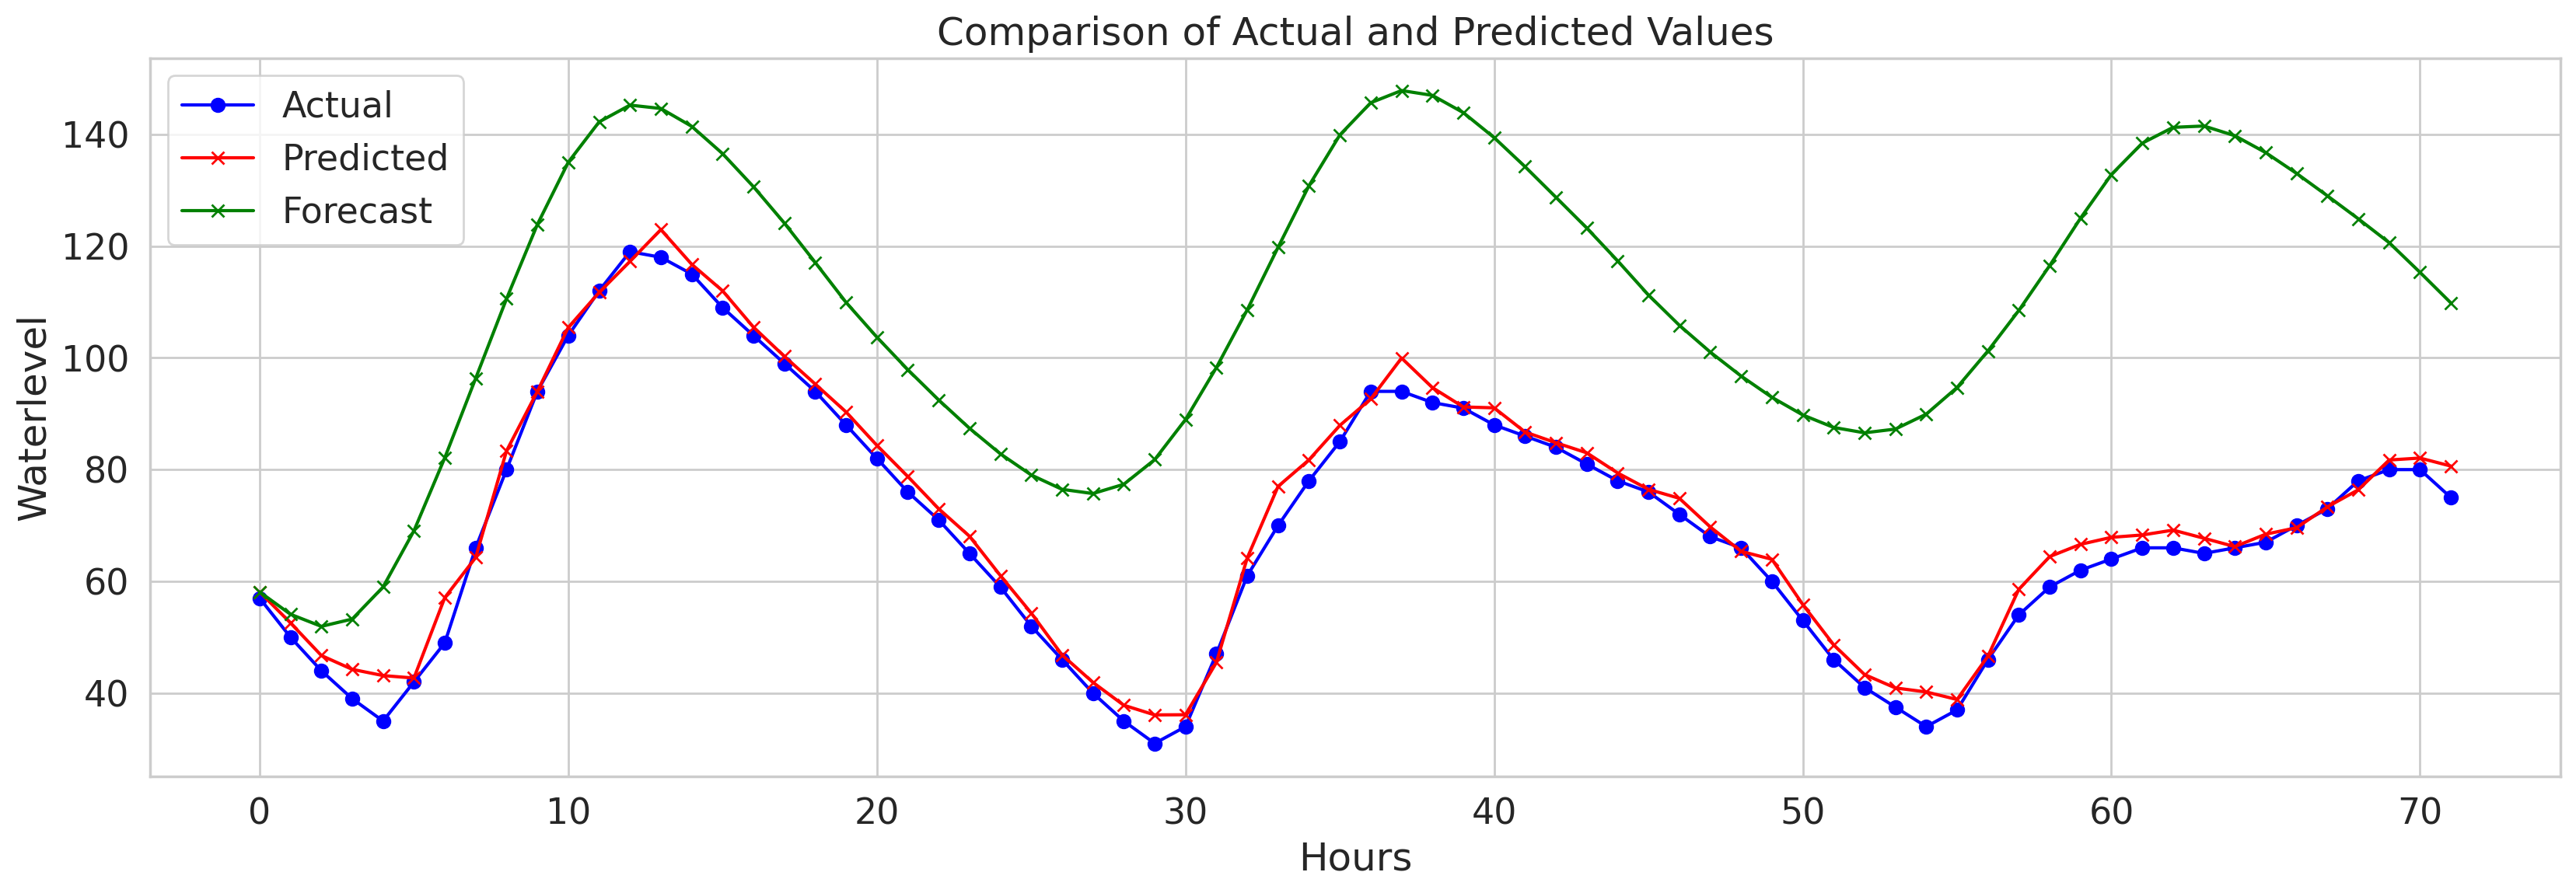

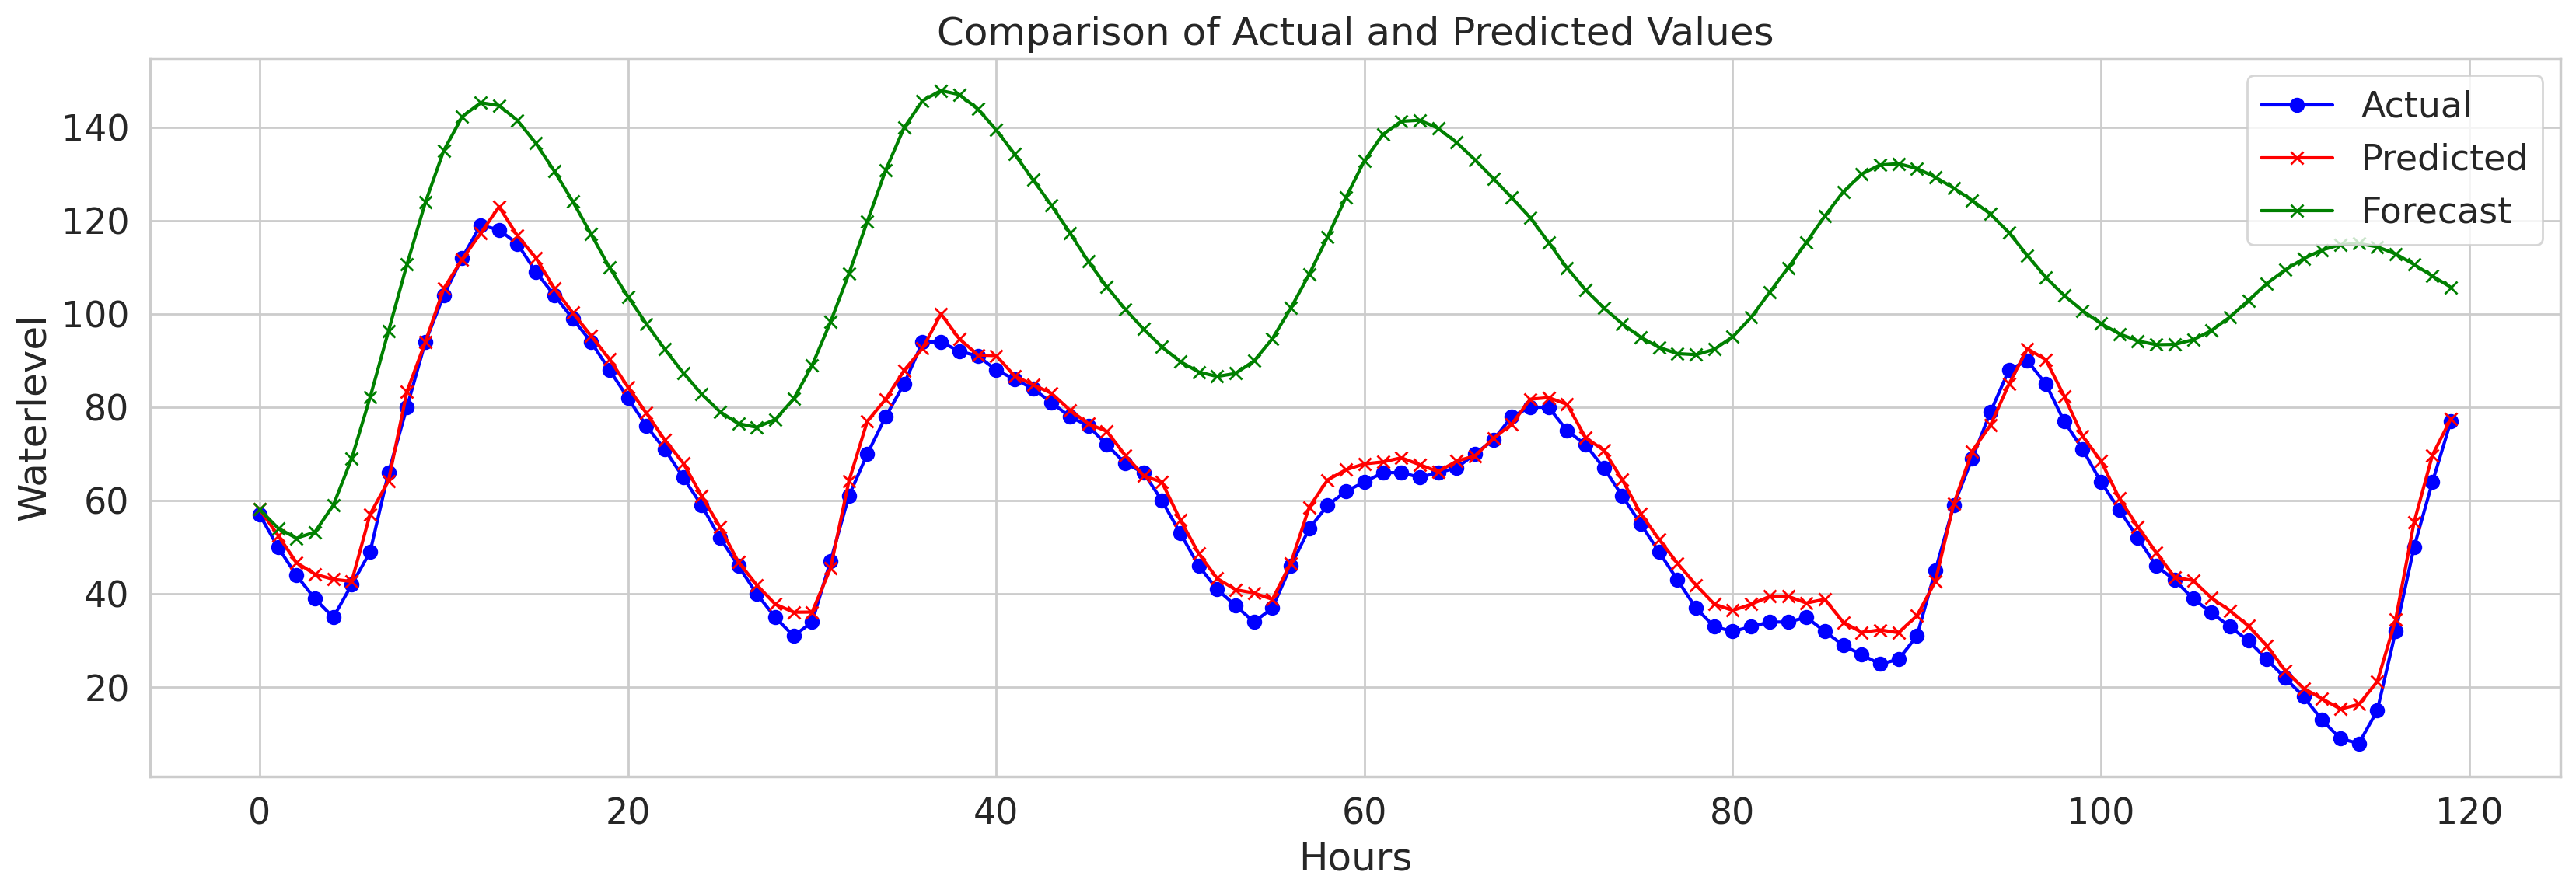

Using model LSTM 3 hours MAE: 4.3866458684205965
Using model LSTM 3 hours RMSE: 5.20252164726936
Using model LSTM 3 hours MSE: 27.066231490306293
Using model LSTM 3 hours R: 0.9920477181112587
Using model LSTM 3 hours SIM: 0.7673372074103696
Using model LSTM 3 hours FSD: 1.8678596890311858
Using model LSTM 3 hours NSE: 0.04096030152457808


Using model LSTM 6 hours MAE: 13.075163981566826
Using model LSTM 6 hours RMSE: 16.28654723501478
Using model LSTM 6 hours MSE: 265.2516208383676
Using model LSTM 6 hours R: -0.11258603930201597
Using model LSTM 6 hours SIM: 0.6771935686886246
Using model LSTM 6 hours FSD: 1.9399048055687091
Using model LSTM 6 hours NSE: -4.076586044753445


Using model LSTM 12 hours MAE: 21.965366323168073
Using model LSTM 12 hours RMSE: 24.68262359817578
Using model LSTM 12 hours MSE: 609.2319076892239
Using model LSTM 12 hours R: 0.9533822030704691
Using model LSTM 12 hours SIM: 0.7893227822784796
Using model LSTM 12 hours FSD: 1.989326943513044
Using model LSTM 

In [84]:
y_fc = forecast(model_LSTM, hours, time)
y_pred = model_LSTM.predict(x_test[time:])

y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)
y_fc_original = scaler.inverse_transform(y_fc)

time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    plt.figure(figsize=(20, 6))
    
    plt.plot(y_test_original[time : time + hours].flatten(), label='Actual', color='blue', marker='o')
    plt.plot(y_pred_original[: hours], label='Predicted', color='red', marker='x')
    plt.plot(y_fc_original[: hours].flatten(), label='Forecast', color='green', marker='x')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Hours')
    plt.ylabel('Waterlevel')
    plt.legend()

    plt.show()
    
for hours in time_forecast:
    metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
    for metric, value in metrics.items():
        print(f'Using model LSTM {hours} hours {metric}: {value}')

    print('\n')

In [85]:
model_LSTM.save('lstm.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# LSTM-es

In [86]:
model_LSTM1 = keras.Sequential()

model_LSTM1.add(keras.layers.LSTM(units=512, activation = 'tanh',
                            return_sequences=True, 
                            input_shape=(x_train.shape[1], 1)))
model_LSTM1.add(Dropout(0.1))
model_LSTM1.add(keras.layers.LSTM(units=256,activation = 'tanh',
                            return_sequences=True))
model_LSTM1.add(Dropout(0.1))
model_LSTM1.add(keras.layers.LSTM(units=64,activation = 'tanh',
                            return_sequences=True))
model_LSTM1.add(Dropout(0.1))
model_LSTM1.add(keras.layers.LSTM(units=32))
model_LSTM1.add(Flatten())
model_LSTM1.add(Dense(32, 'relu'))
model_LSTM1.add(Dropout(0.1))
model_LSTM1.add(Dense((1), 'linear'))

model_LSTM1.compile(
  loss=MeanSquaredError(),
  optimizer=Adam(learning_rate=0.0001),
  metrics=[RootMeanSquaredError()]
)
model_LSTM1.summary()
model_LSTM1.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', 
                             patience=10, 
                             restore_best_weights=True)],                       
    verbose=1,
    shuffle=False
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 163, 512)          1052672   
                                                                 
 dropout_12 (Dropout)        (None, 163, 512)          0         
                                                                 
 lstm_13 (LSTM)              (None, 163, 256)          787456    
                                                                 
 dropout_13 (Dropout)        (None, 163, 256)          0         
                                                                 
 lstm_14 (LSTM)              (None, 163, 64)           82176     
                                                                 
 dropout_14 (Dropout)        (None, 163, 64)           0         
                                                                 
 lstm_15 (LSTM)              (None, 32)               

293/293 [==============================] - 6s 20ms/step


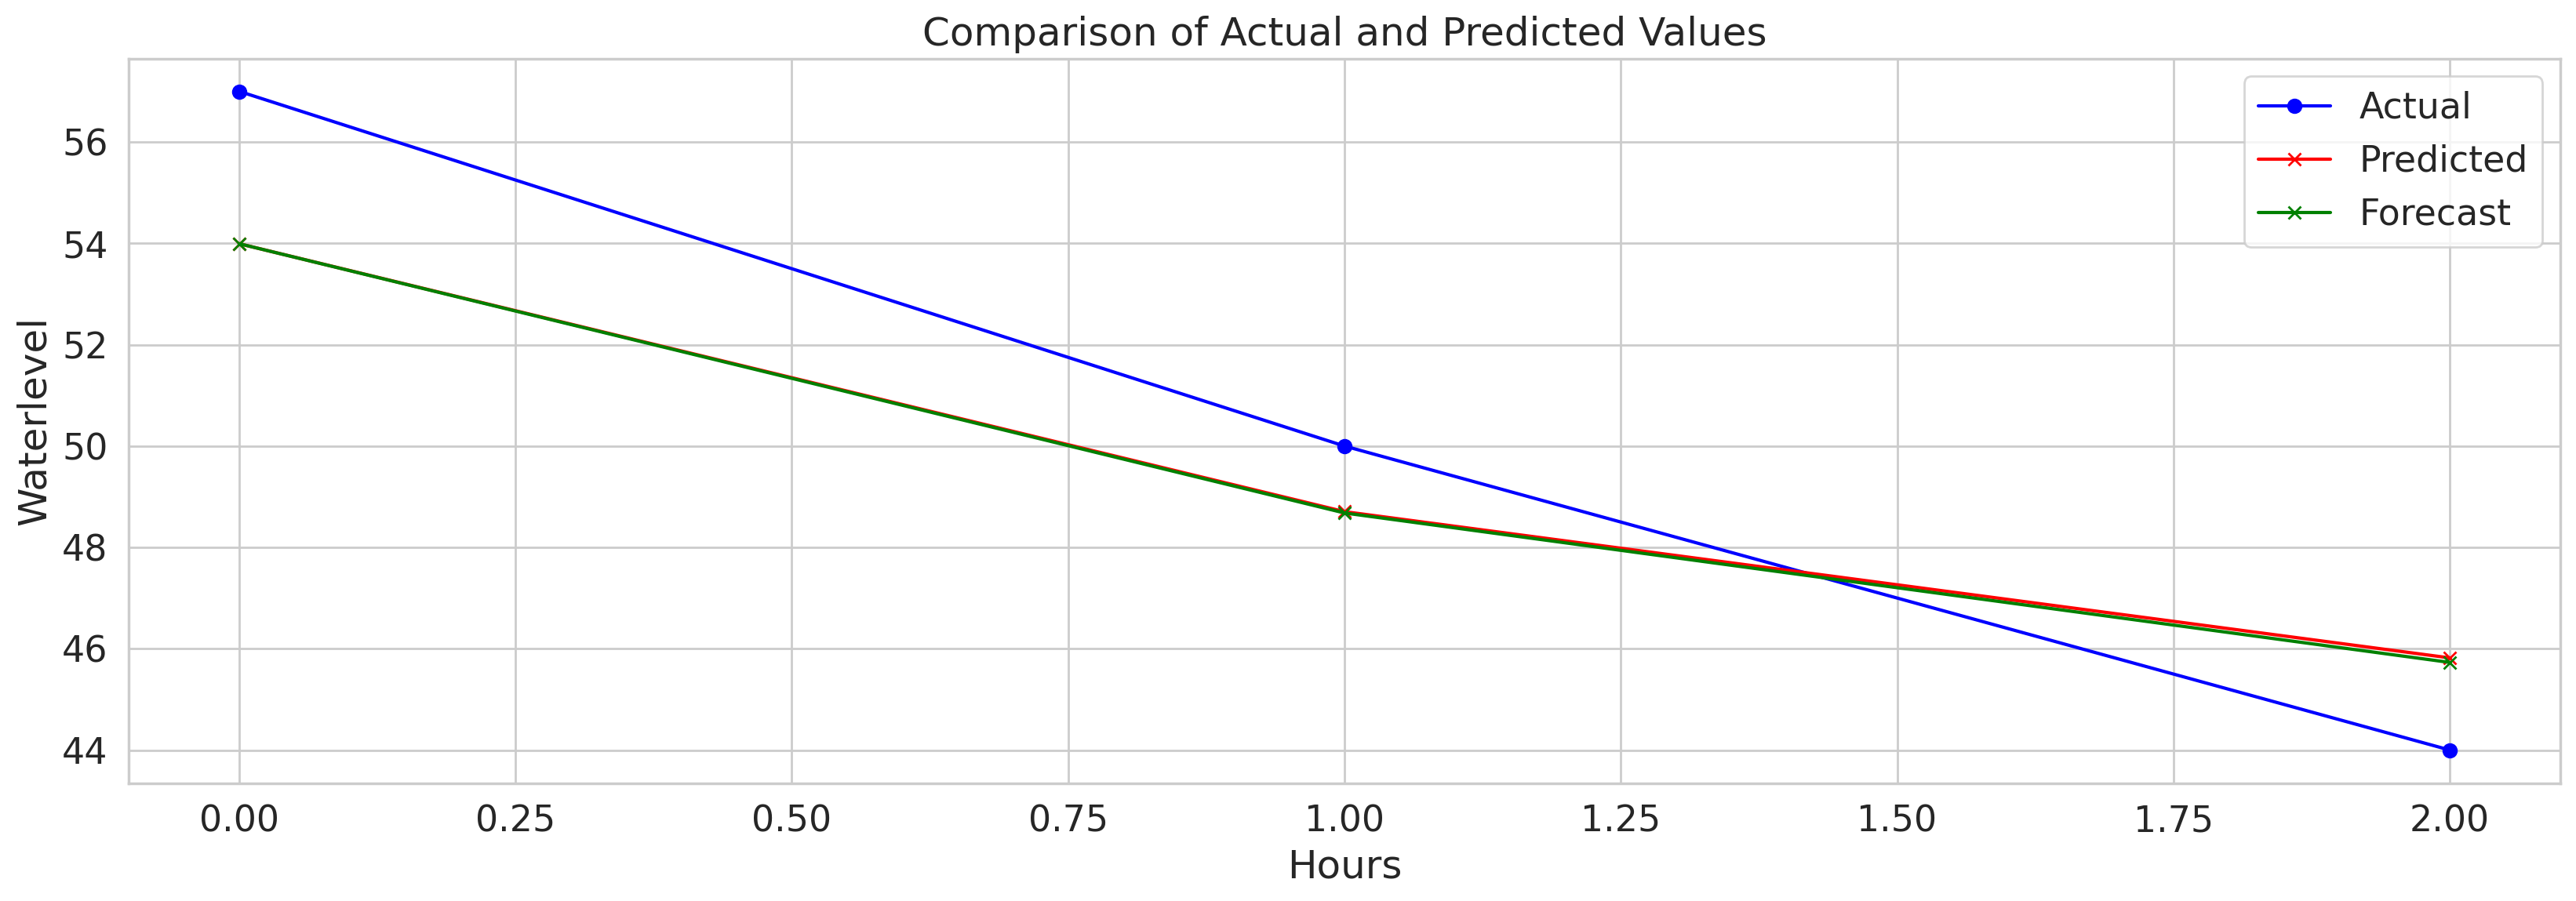

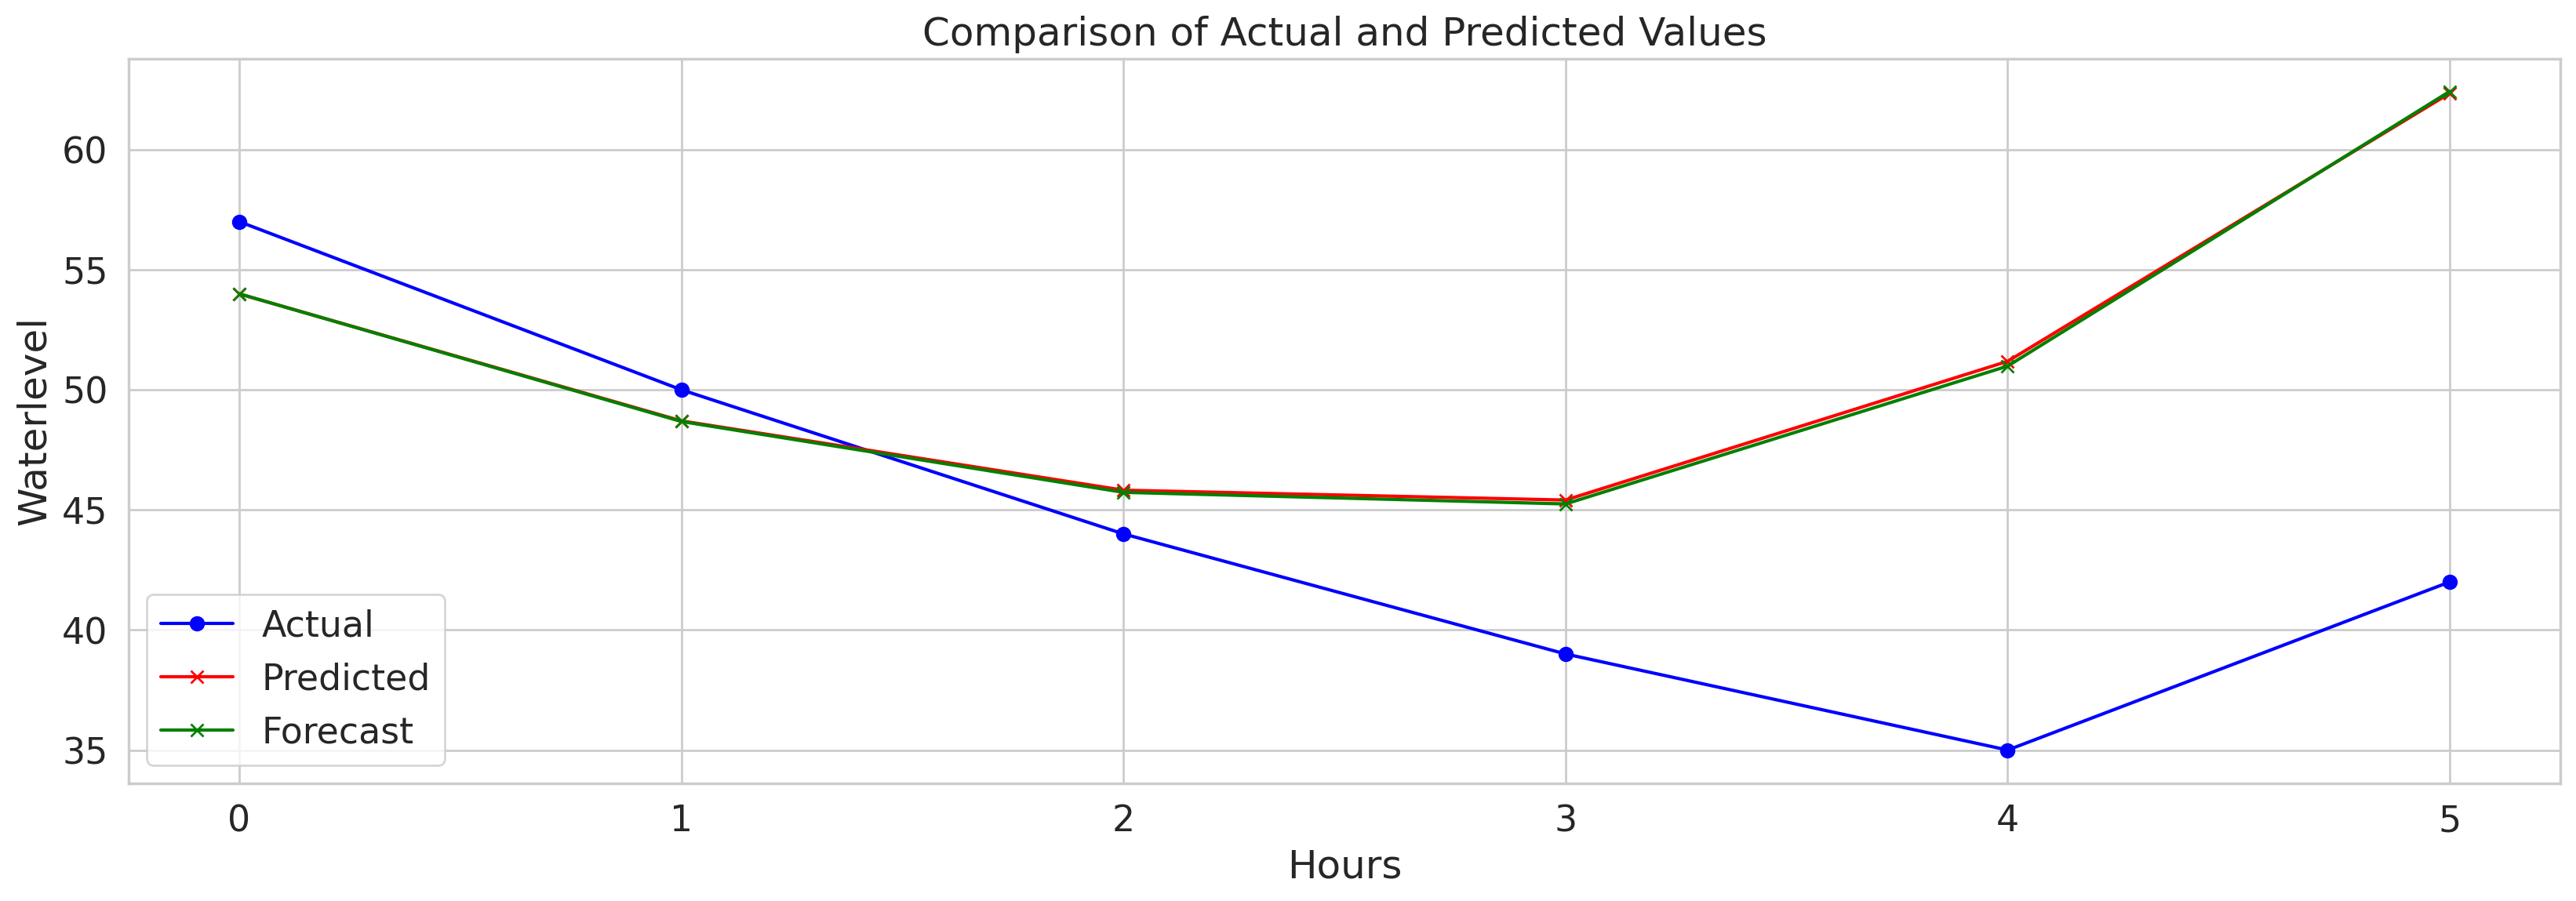

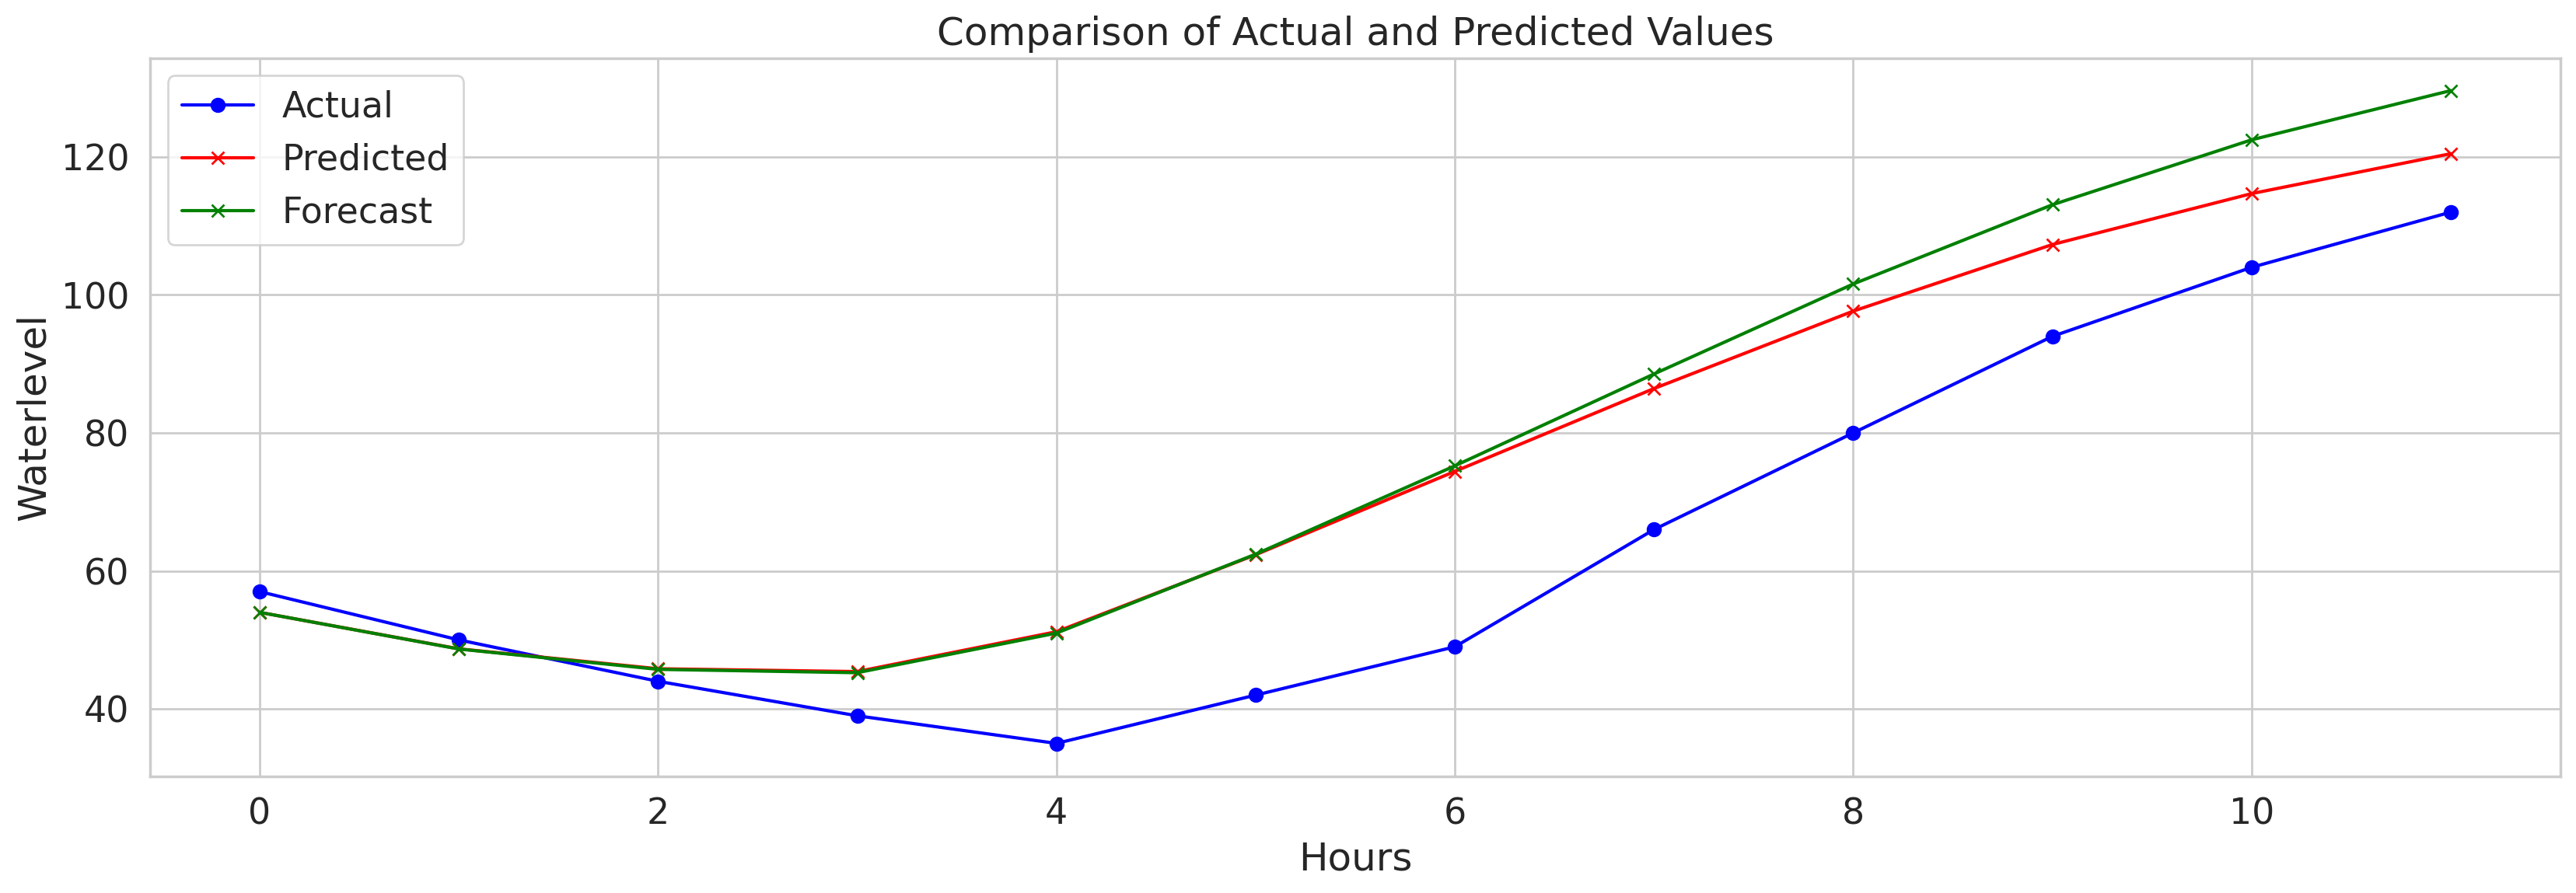

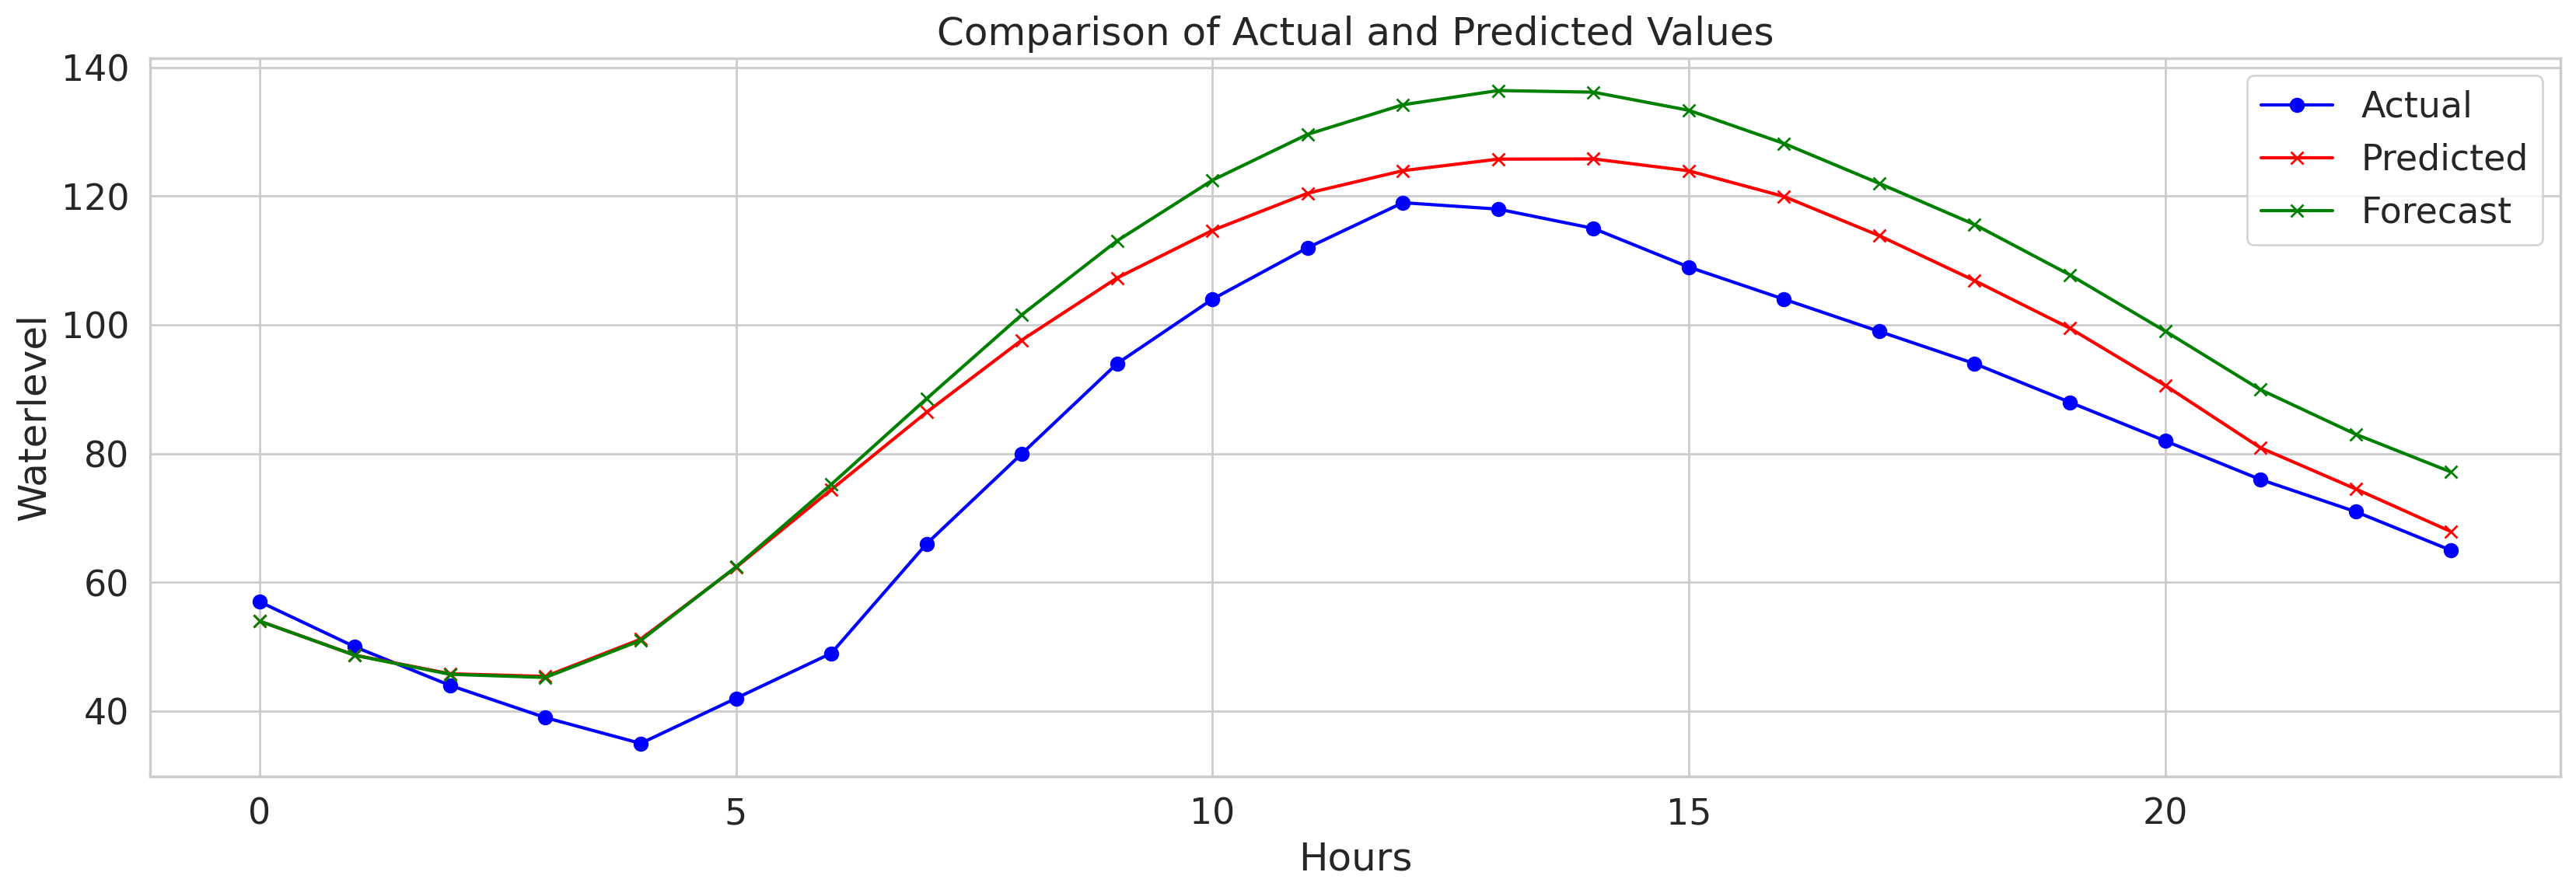

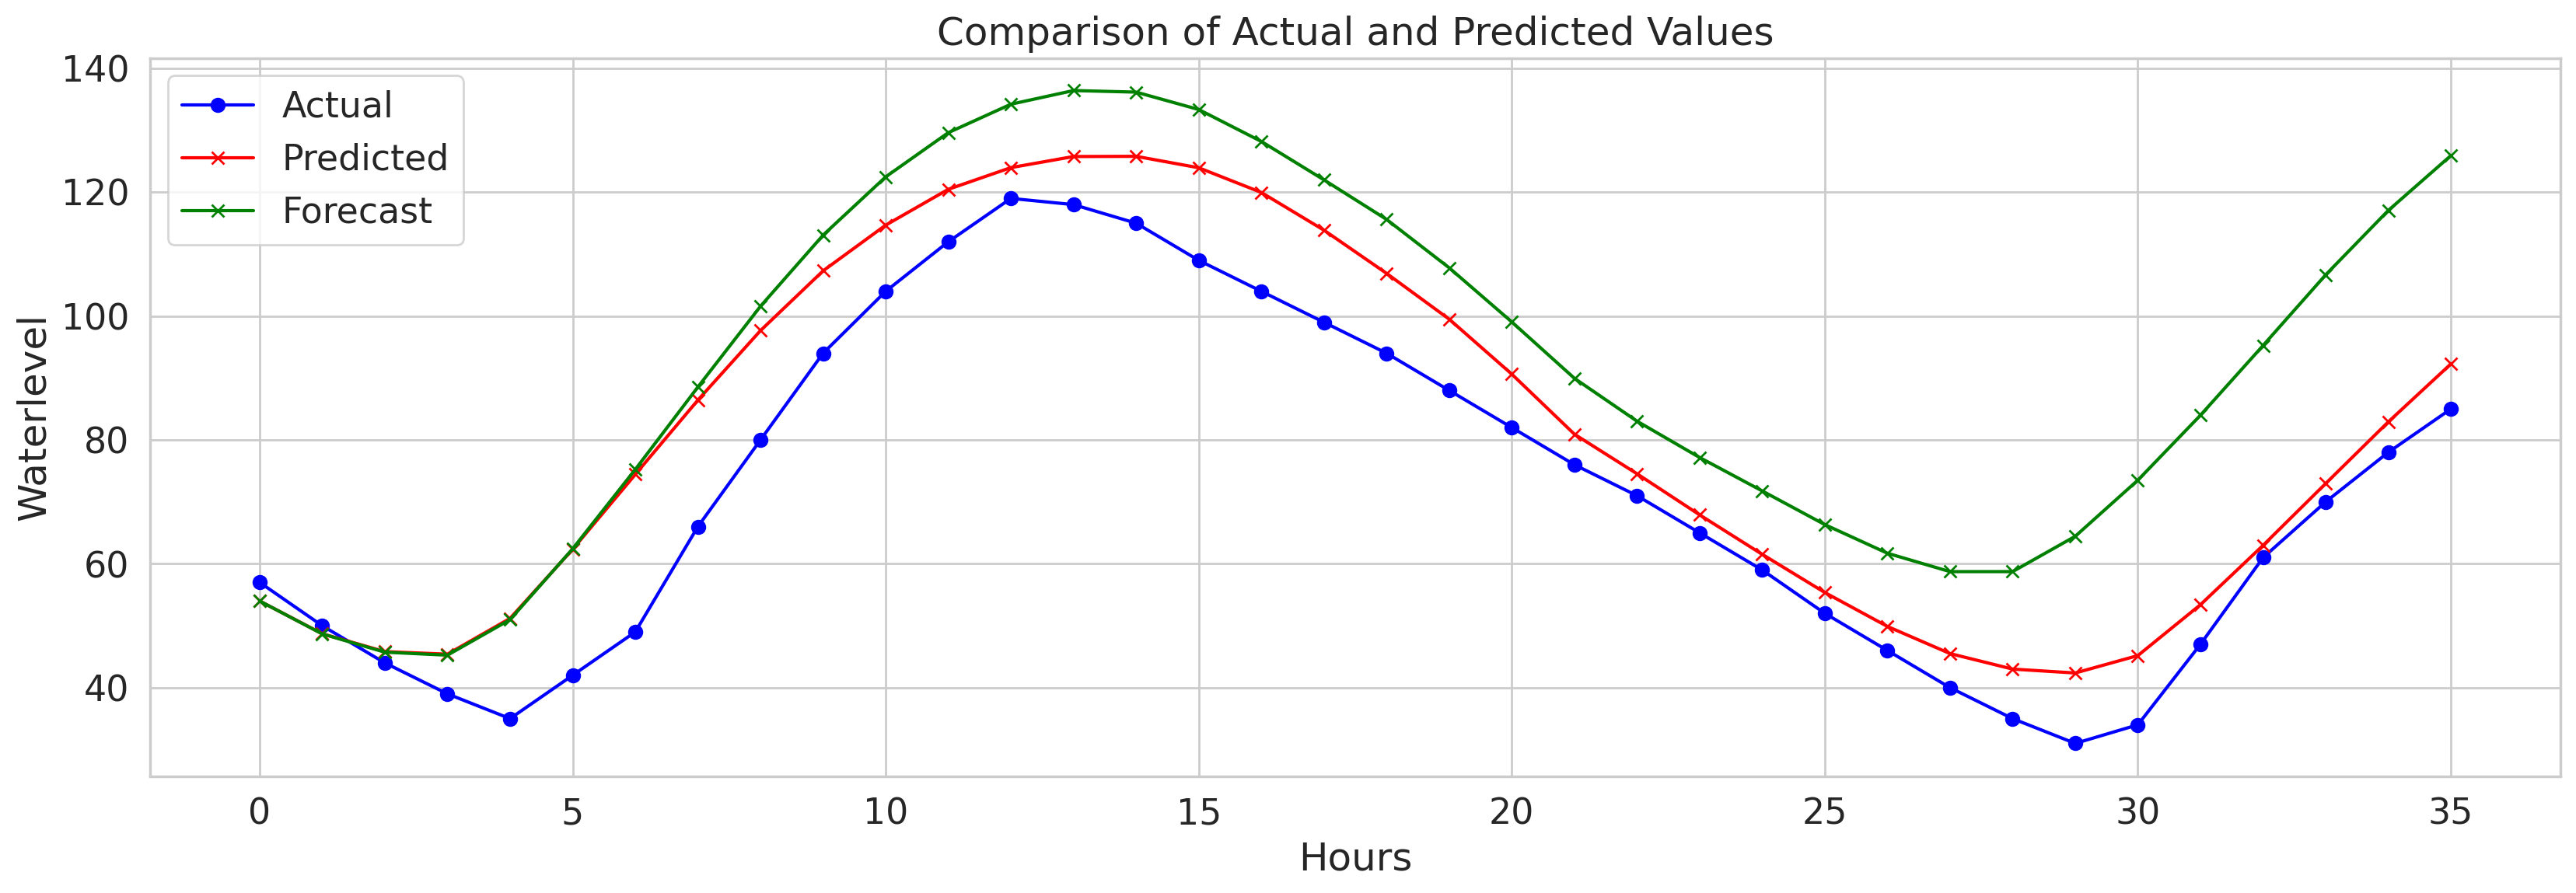

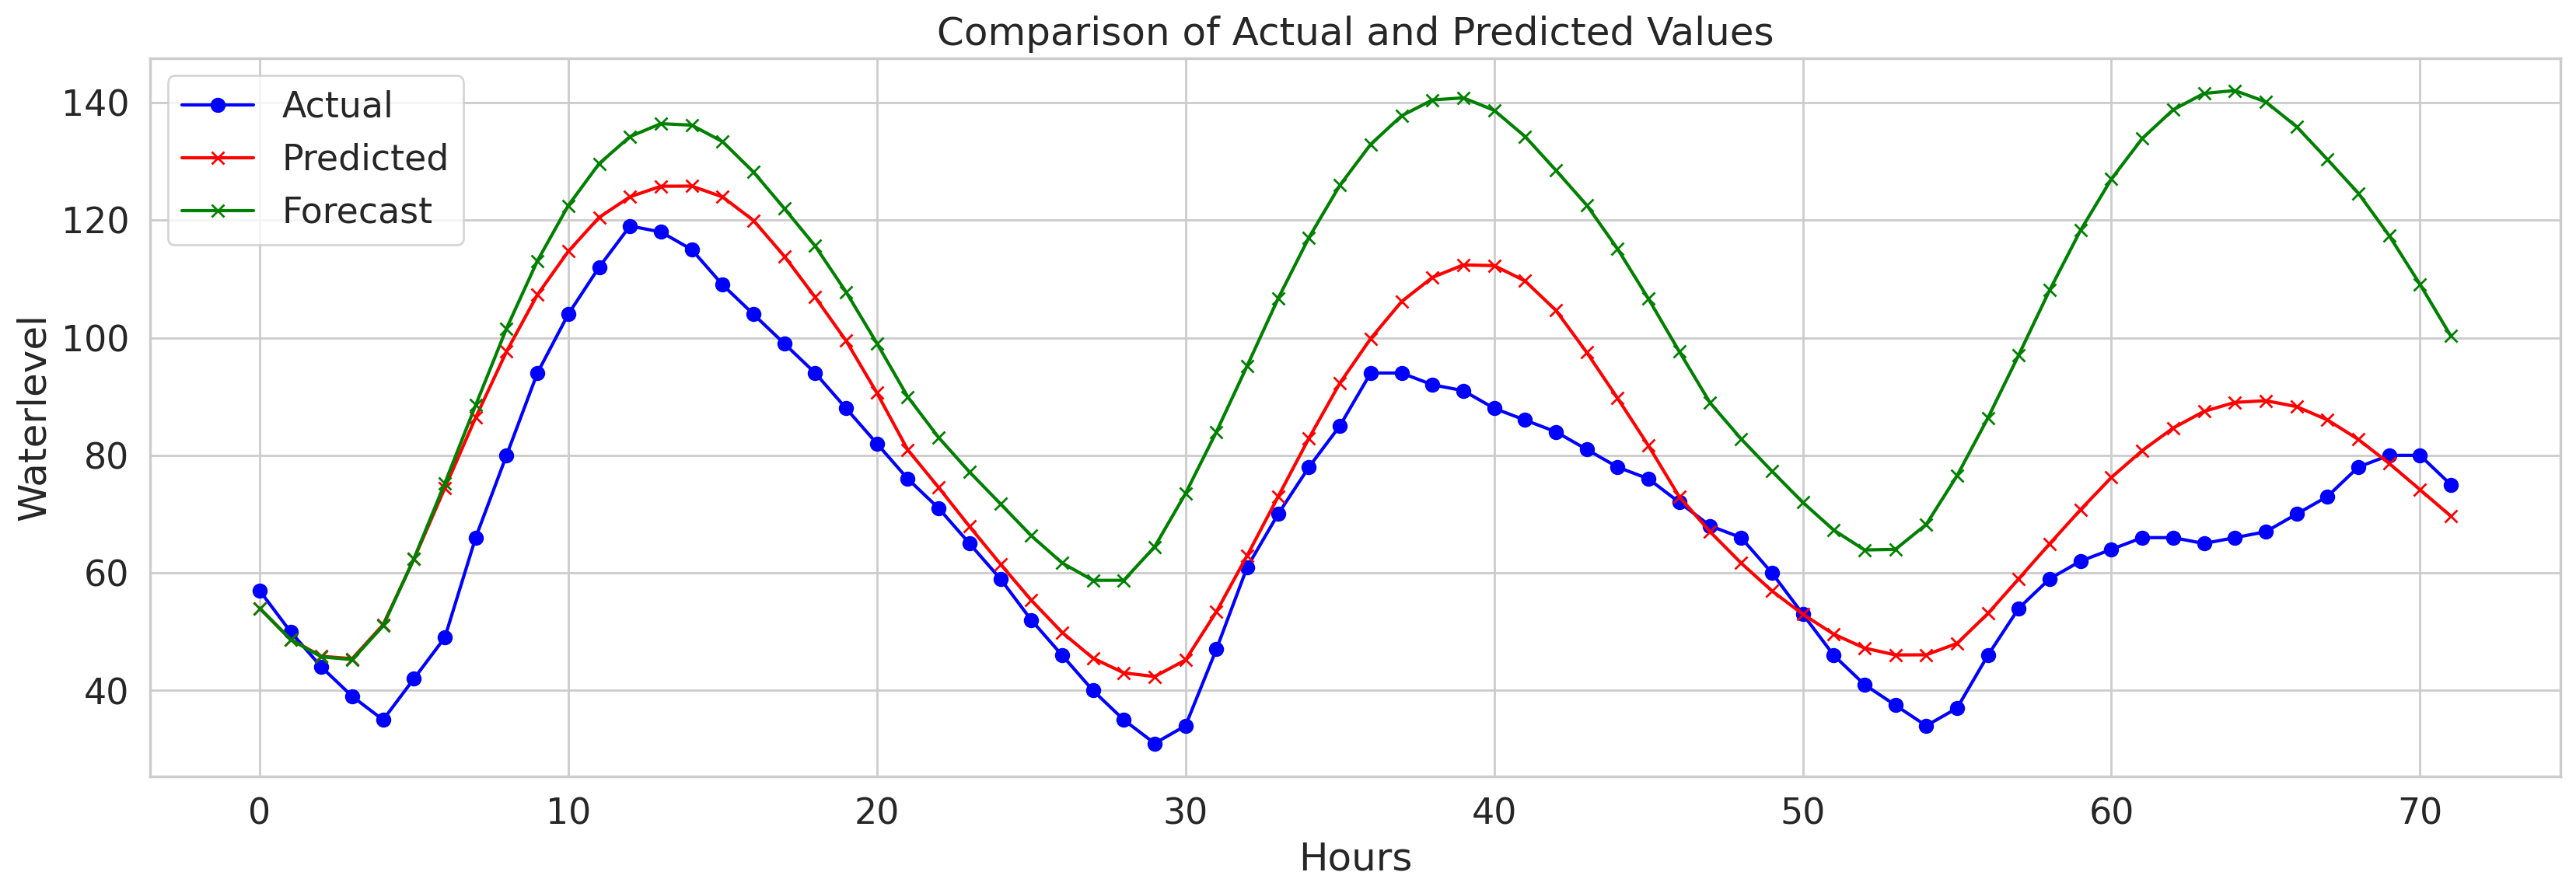

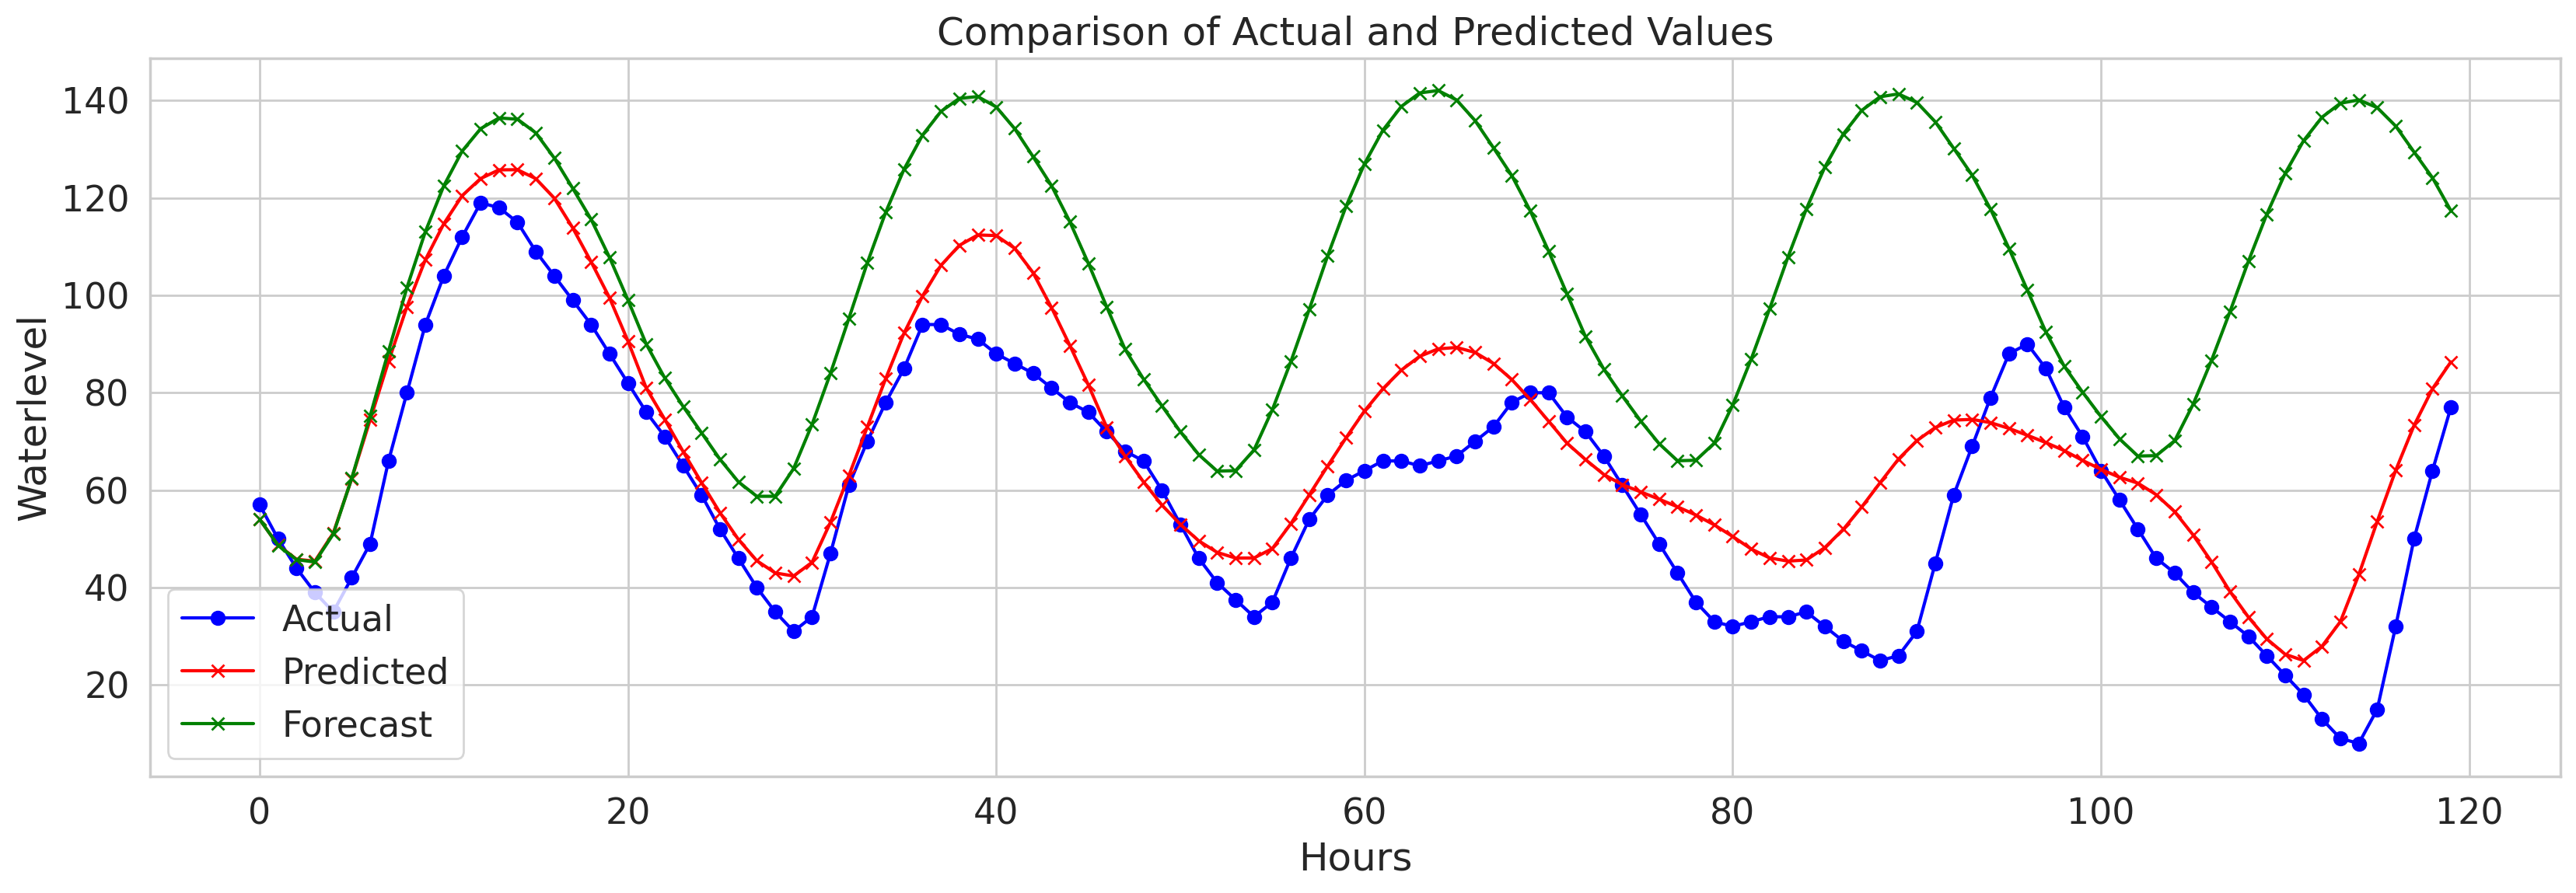

Using model LSTM 3 hours MAE: 2.0191149090727123
Using model LSTM 3 hours RMSE: 2.143029510111783
Using model LSTM 3 hours MSE: 4.592575481209948
Using model LSTM 3 hours R: 0.9928890136807671
Using model LSTM 3 hours SIM: 0.8674981437897319
Using model LSTM 3 hours FSD: 1.9004590092864815
Using model LSTM 3 hours NSE: 0.8372709475161826


Using model LSTM 6 hours MAE: 8.118362656484047
Using model LSTM 6 hours RMSE: 10.995269826851313
Using model LSTM 6 hours MSE: 120.8959585652669
Using model LSTM 6 hours R: 0.12023449329717217
Using model LSTM 6 hours SIM: 0.7711478742124314
Using model LSTM 6 hours FSD: 1.9412370763426707
Using model LSTM 6 hours NSE: -1.3137982500529541


Using model LSTM 12 hours MAE: 14.520038448895013
Using model LSTM 12 hours RMSE: 16.84045088218212
Using model LSTM 12 hours MSE: 283.6007859151886
Using model LSTM 12 hours R: 0.9545967599341184
Using model LSTM 12 hours SIM: 0.8491024057873063
Using model LSTM 12 hours FSD: 1.9885411475368004
Using model LSTM 

In [87]:
y_fc = forecast(model_LSTM1, hours, time)
y_pred = model_LSTM1.predict(x_test[time:])

y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)
y_fc_original = scaler.inverse_transform(y_fc)

time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    plt.figure(figsize=(20, 6))
    
    plt.plot(y_test_original[time : time + hours].flatten(), label='Actual', color='blue', marker='o')
    plt.plot(y_pred_original[: hours], label='Predicted', color='red', marker='x')
    plt.plot(y_fc_original[: hours].flatten(), label='Forecast', color='green', marker='x')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Hours')
    plt.ylabel('Waterlevel')
    plt.legend()

    plt.show()
    
for hours in time_forecast:
    metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
    for metric, value in metrics.items():
        print(f'Using model LSTM {hours} hours {metric}: {value}')

    print('\n')

In [88]:
model_LSTM1.save('lstm_es.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# LSTM-AM

In [ ]:
model_lstm_am = keras.Sequential()

model_lstm_am.add(keras.layers.LSTM(units=512, activation = 'tanh',
                            return_sequences=True, 
                            input_shape=(x_train.shape[1], 1)))
model_lstm_am.add(Dropout(0.1))
model_lstm_am.add(keras.layers.LSTM(units=256,activation = 'tanh',
                            return_sequences=True))
model_lstm_am.add(Dropout(0.1))
model_lstm_am.add(keras.layers.LSTM(units=64,activation = 'tanh',
                            return_sequences=True))
model_lstm_am.add(Dropout(0.1))
model_lstm_am.add(keras.layers.LSTM(units=32))

model_lstm_am.add(AttentionLayer())

model_lstm_am.add(Flatten())
model_lstm_am.add(Dense(32, 'relu'))
model_lstm_am.add(Dropout(0.1))
model_lstm_am.add(Dense((1), 'linear'))

model_lstm_am.compile(
  loss=MeanSquaredError(),
  optimizer=Adam(learning_rate=0.0001),
  metrics=[RootMeanSquaredError()]
)
model_lstm_am.summary()
model_lstm_am.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,                       
    verbose=1,
    shuffle=False
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 163, 512)          1052672   
                                                                 
 dropout_16 (Dropout)        (None, 163, 512)          0         
                                                                 
 lstm_17 (LSTM)              (None, 163, 256)          787456    
                                                                 
 dropout_17 (Dropout)        (None, 163, 256)          0         
                                                                 
 lstm_18 (LSTM)              (None, 163, 64)           82176     
                                                                 
 dropout_18 (Dropout)        (None, 163, 64)           0         
                                                                 
 lstm_19 (LSTM)              (None, 32)               

In [ ]:
y_fc = forecast(model_lstm_am, hours, time)
y_pred = model_lstm_am.predict(x_test[time:])

y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)
y_fc_original = scaler.inverse_transform(y_fc)

time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    plt.figure(figsize=(20, 6))
    
    plt.plot(y_test_original[time : time + hours].flatten(), label='Actual', color='blue', marker='o')
    plt.plot(y_pred_original[: hours], label='Predicted', color='red', marker='x')
    plt.plot(y_fc_original[: hours].flatten(), label='Forecast', color='green', marker='x')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Hours')
    plt.ylabel('Waterlevel')
    plt.legend()

    plt.show()
    
for hours in time_forecast:
    metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
    for metric, value in metrics.items():
        print(f'Using model LSTM {hours} hours {metric}: {value}')

    print('\n')

In [ ]:
model_lstm_am.save('lstm_am.h5')

# LSTM-AM-es

In [ ]:
model_lstm_am_es = keras.Sequential()

model_lstm_am_es.add(keras.layers.LSTM(units=512, activation = 'tanh',
                            return_sequences=True, 
                            input_shape=(x_train.shape[1], 1)))
model_lstm_am_es.add(Dropout(0.1))
model_lstm_am_es.add(keras.layers.LSTM(units=256,activation = 'tanh',
                            return_sequences=True))
model_lstm_am_es.add(Dropout(0.1))
model_lstm_am_es.add(keras.layers.LSTM(units=64,activation = 'tanh',
                            return_sequences=True))
model_lstm_am_es.add(Dropout(0.1))
model_lstm_am_es.add(keras.layers.LSTM(units=32))

model_lstm_am_es.add(AttentionLayer())

model_lstm_am_es.add(Flatten())
model_lstm_am_es.add(Dense(32, 'relu'))
model_lstm_am_es.add(Dropout(0.1))
model_lstm_am_es.add(Dense((1), 'linear'))

model_lstm_am_es.compile(
  loss=MeanSquaredError(),
  optimizer=Adam(learning_rate=0.0001),
  metrics=[RootMeanSquaredError()]
)
model_lstm_am_es.summary()
model_lstm_am_es.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', 
                             patience=10, 
                             restore_best_weights=True)],
    epochs=100,
    batch_size=32,                       
    verbose=1,
    shuffle=False
)

In [ ]:
y_fc = forecast(model_lstm_am_es, hours, time)
y_pred = model_lstm_am_es.predict(x_test[time:])

y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)
y_fc_original = scaler.inverse_transform(y_fc)

time_forecast = [3,  6, 12, 24, 36, 72, 120]
for hours in time_forecast:
    plt.figure(figsize=(20, 6))
    
    plt.plot(y_test_original[time : time + hours].flatten(), label='Actual', color='blue', marker='o')
    plt.plot(y_pred_original[: hours], label='Predicted', color='red', marker='x')
    plt.plot(y_fc_original[: hours].flatten(), label='Forecast', color='green', marker='x')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Hours')
    plt.ylabel('Waterlevel')
    plt.legend()

    plt.show()
    
for hours in time_forecast:
    metrics = calculate_metrics(y_test_original[time : time + hours].flatten(), y_fc_original[:hours].flatten())
    for metric, value in metrics.items():
        print(f'Using model LSTM {hours} hours {metric}: {value}')

    print('\n')

In [ ]:
model_lstm_am_es.save('lstm_am_es.h5')